In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.backends.backend_pdf
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from scipy.stats import pearsonr

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)

act_directory = 'C:\\Users\insan\\Desktop\\Camera_Cache'



In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import os
import matplotlib.pyplot as plt
import dlc2kinematics

C:\Users\insan\anaconda3\envs\Ephyanalysis\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
animals_in_cache = []
EnumSession = []
EnumClust = []
EnumOnlySession = []

for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    animals_in_cache.append(sessionfile.meta.animal)

    if not sessionfile.meta.region == 'AC':
        continue
    
    EnumOnlySession.append(session)
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)
        
        
animals_in_cache = np.unique(animals_in_cache)

100%|██████████| 2/2 [00:00<00:00, 78.90it/s]


In [4]:
sessionfile_D7 = ilep.loadSessionCached(act_directory,EnumOnlySession[0])
sessionfile_D9 = ilep.loadSessionCached(act_directory,EnumOnlySession[1])

In [5]:
#Classify NCR_CR

##############FRmod_baseline might be changed later(median from pre_early tuning animals)
FRmod_baseline = 3.782654127481714

NCR_D7 = []
for clust in sessionfile_D7.clusters.good:
    if sessionfile_D7.responsiveness[clust]['all_trials'].FRmodulation < FRmod_baseline:
        NCR_D7.append(clust)
#print(NCR_D7)

NCR_D9 = []
CR_D9 = []
for clust in sessionfile_D9.clusters.good:
    if sessionfile_D9.responsiveness[clust]['all_trials'].FRmodulation < FRmod_baseline:
        NCR_D9.append(clust)
    else:
        CR_D9.append(clust)
print(NCR_D9)
print(CR_D9)

print(len(NCR_D9))
print(len(CR_D9))

[8, 33, 43, 44, 59, 92, 96]
[3, 13, 15, 19, 31, 50, 77, 87, 88, 90, 91]
7
11


In [6]:
#3003 movement data

dataname3 = 'C:\\Users\insan\\Desktop\\IR Camera Videos\\Day 9\\AE_231_3\\CogRig_AE_231_2023-02-14_3DLC_resnet50_Training_projectMar3shuffle1_500000.h5'
dataframe3 = pd.read_hdf(os.path.join(dataname3))

df_Hand3 = dataframe3.iloc[:,9:11]
df_Mouth3 = dataframe3.iloc[:,3:5]
df_Whisker3 = dataframe3.iloc[:,6:8]
df_Nose3 = dataframe3.iloc[:,12:14]

In [7]:
dataframe3

scorer    DLC_resnet50_Training_projectMar3shuffle1_500000              \
bodyparts                                              Ear               
coords                                                   x           y   
0                                               365.569733  314.891205   
1                                               364.777313  314.208099   
2                                               364.813995  314.041229   
3                                               365.157074  314.371124   
4                                               382.732758  306.522339   
...                                                    ...         ...   
47950                                           381.755737  298.842529   
47951                                           381.597229  298.264587   
47952                                           381.591919  297.654205   
47953                                           381.208160  298.493011   
47954                                           381.084167  297.003540   

scorer                                                               \
bodyparts                  Mouth                            Whisker   
coords    likelihood           x           y likelihood           x   
0           0.000655  244.629730  302.147156        1.0  228.174377   
1           0.000544  241.721451  302.179840        1.0  227.583679   
2           0.000474  241.524292  302.154999        1.0  227.416489   
3           0.000653  241.930573  300.753204        1.0  227.476715   
4           0.000503  242.452591  301.695862        1.0  227.723419   
...              ...         ...         ...        ...         ...   
47950       0.000520  243.719635  304.617706        1.0  227.989304   
47951       0.000617  242.587402  303.633728        1.0  227.942169   
47952       0.000818  244.302704  303.640076        1.0  228.186539   
47953       0.000569  243.681488  303.073608        1.0  228.168427   
47954       0.000968  243.449585  301.728607        1.0  228.235275   

scorer                                                               \
bodyparts                               Hand                          
coords              y likelihood           x           y likelihood   
0          260.918701        1.0  370.713684  308.545898        1.0   
1          260.602448        1.0  370.643921  307.567932        1.0   
2          260.341217        1.0  372.733337  307.104309        1.0   
3          260.916473        1.0  371.886047  308.427704        1.0   
4          261.072205        1.0  371.747223  307.421448        1.0   
...               ...        ...         ...         ...        ...   
47950      261.571808        1.0  384.687836  294.618286        1.0   
47951      261.849976        1.0  385.352875  293.639740        1.0   
47952      261.125153        1.0  386.683868  292.744324        1.0   
47953      260.950500        1.0  385.432281  293.288574        1.0   
47954      260.290863        1.0  386.918427  291.920380        1.0   

scorer                                        
bodyparts        Nose                         
coords              x           y likelihood  
0          181.809357  292.558380        1.0  
1          181.889221  293.501160        1.0  
2          182.134338  293.344971        1.0  
3          182.314331  293.513977        1.0  
4          183.110214  294.593567        1.0  
...               ...         ...        ...  
47950      183.179901  295.465729        1.0  
47951      182.791977  295.136536        1.0  
47952      182.692856  294.588318        1.0  
47953      182.012329  294.451355        1.0  
47954      183.887527  293.271362        1.0  

[47955 rows x 15 columns]

In [8]:
#not used
mouth3_x = df_Mouth3.iloc[:,0].to_numpy()
mouth3_y = df_Mouth3.iloc[:,1].to_numpy()

nose3_x = df_Nose3.iloc[:,0].to_numpy()
nose3_y = df_Nose3.iloc[:,0].to_numpy()

hand3_x = df_Hand3.iloc[:,0].to_numpy()
hand3_y = df_Hand3.iloc[:,1].to_numpy()

In [9]:
#Calculate speed for each body part
df3, bodyparts, scorer = dlc2kinematics.load_data(dataname3)

df_speed_Hand3 = dlc2kinematics.compute_speed(df3,bodyparts=['Hand'])
df_speed_Mouth3 = dlc2kinematics.compute_speed(df3,bodyparts=['Mouth'])
df_speed_Nose3 = dlc2kinematics.compute_speed(df3,bodyparts=['Nose'])
df_speed_Whisker3 = dlc2kinematics.compute_speed(df3,bodyparts=['Whisker'])

In [10]:
df_speed_Mouth3

scorer    DLC_resnet50_Training_projectMar3shuffle1_500000           
bodyparts                                            Mouth           
coords                                               speed likelihood
0                                                 1.552724        1.0
1                                                 1.552724        1.0
2                                                 0.720941        1.0
3                                                 0.517819        1.0
4                                                 0.354592        1.0
...                                                    ...        ...
47950                                             0.748266        1.0
47951                                             0.569151        1.0
47952                                             0.614564        1.0
47953                                             1.046604        1.0
47954                                             1.046604        1.0

[47955 rows x 2 columns]

In [11]:
df_speed_Hand3.iloc[:,0]

0        1.240683
1        1.240683
2        0.755329
3        0.517928
4        0.528903
           ...   
47950    0.527930
47951    1.368930
47952    0.180016
47953    0.428340
47954    0.428340
Name: (DLC_resnet50_Training_projectMar3shuffle1_500000, Hand, speed), Length: 47955, dtype: float64

In [12]:
#Create speed numpy array for each body part
speed_Hand3 = df_speed_Hand3.iloc[:,0].to_numpy()
print(np.median(speed_Hand3))
speed_Mouth3 = df_speed_Mouth3.iloc[:,0].to_numpy()
print(np.median(speed_Mouth3))
speed_Nose3 = df_speed_Nose3.iloc[:,0].to_numpy()
print(np.median(speed_Nose3))
speed_Whisker3 = df_speed_Whisker3.iloc[:,0].to_numpy()
print(np.median(speed_Whisker3))

0.6955070936552264
0.6168661511264609
0.5223573709051211
0.3832671791582503


In [13]:
#Create arrays for camera recording 3002(NOT USED in this analysis)
timefile2=np.load('C:\\Users\insan\\Desktop\\IR Camera Videos\\Day 9\\AE_231_2\TIMESTAMPS_CogRig_AE_231_2023-02-14_2.npy')
dataname2 = 'C:\\Users\insan\\Desktop\\IR Camera Videos\\Day 9\\AE_231_2\\CogRig_AE_231_2023-02-14_2DLC_resnet50_Training_projectMar3shuffle1_500000.h5'
dataframe2 = pd.read_hdf(os.path.join(dataname2))
df_Hand2 = dataframe2.iloc[:,9:11]
df2, bodyparts, scorer = dlc2kinematics.load_data(dataname2)
df_speed_Hand2 = dlc2kinematics.compute_speed(df2,bodyparts=['Hand'])
hand2_x = df_Hand2.iloc[:,0].to_numpy()
hand2_y = df_Hand2.iloc[:,1].to_numpy()
speed_Hand2 = df_speed_Hand2.iloc[:,0].to_numpy()

In [14]:
#about 1s = 100 frames,25s = 2500frames

In [15]:
#Create time array for timefile3
timefile3=np.load('C:\\Users\insan\\Desktop\\IR Camera Videos\\Day 9\\AE_231_3\\TIMESTAMPS_CogRig_AE_231_2023-02-14_3.npy')
timefile3_arr = np.array(timefile3)

import datetime
video_timestamp3 = []
for unix_time in timefile3:
    time = datetime.datetime.fromtimestamp(unix_time).strftime('%Y-%m-%d %H:%M:%S')
    video_timestamp3.append(time)

#test
print(timefile3[0])
print(video_timestamp3[0])


1676410762.3275287
2023-02-14 16:39:22


In [16]:
#Create important time point variables for AE_231_02_14_23_3001,3002,3003

#first neural session start time:2023	2	2	14	21	21	42	100 = 1676409702.100
#second neural session start time:2023	2	2	14	21	30	41	94 = 1676410241.094
#third neural session start time: 2023	2	2	14	21	39	23	380 = 1676410763.380
neural_s1_start_date = 1676409702.100
neural_s2_start_date = 1676410241.094
neural_s3_start_date = 1676410763.380

neural_s1_duration = 527.3762
neural_s2_duration = 511.0905

neural_s1_end_date = neural_s1_start_date + neural_s1_duration
neural_s2_end_date = neural_s2_start_date + neural_s2_duration

s1_s2_between_duration = neural_s2_start_date - neural_s1_end_date
s2_s3_between_duration = neural_s3_start_date - neural_s2_end_date


In [17]:
s3_start_second = neural_s3_start_date - s1_s2_between_duration -s2_s3_between_duration - neural_s1_start_date

In [18]:
s3_start_second

1038.4667000770569

In [19]:
s3_start_samples = s3_start_second*30000

In [20]:
trials_start = sessionfile_D9.trials.starts
trials_end = sessionfile_D9.trials.ends

trial_window = np.zeros((len(trials_start),2))

for idx in range(len(trial_window)):
    trial_window[idx][0] = trials_start[idx]
    trial_window[idx][1] = trials_end[idx]
    
trial_window_3003 = trial_window[-100:]
trial_start_3003 = trials_start[-100:]

response_time = sessionfile_D9.trials.response
reward_time = sessionfile_D9.behavior.reward_times

In [21]:
print(neural_s3_start_date)
print(timefile3[105])
print(timefile3[106])

print(timefile3[105]-neural_s3_start_date)
print(timefile3[106]-neural_s3_start_date)

video3003_start_frame = 105

1676410763.38
1676410763.3777246
1676410763.387698
-0.0022754669189453125
0.0076978206634521484


In [22]:
#Mouth  

In [23]:
move_3003_start_date = timefile3 - s1_s2_between_duration - s2_s3_between_duration
move_3003_start_seconds = move_3003_start_date - neural_s1_start_date
move_3003_start_samples = move_3003_start_seconds*30000

In [24]:
#window is set to be 100 frames
mouth_speed_diff_3003_arr = []
for frame_idx,speed in enumerate(speed_Mouth3):
    if frame_idx>video3003_start_frame-1:
        speed_diff = np.mean(speed_Mouth3[frame_idx:frame_idx+100])-np.mean(speed_Mouth3[frame_idx-100:frame_idx])
        mouth_speed_diff_3003_arr.append(speed_diff)
        
mouth_speed_diff_3003_arr = np.array(mouth_speed_diff_3003_arr)
print(len(mouth_speed_diff_3003_arr))

47850


In [25]:
mouth_speed_3003_std = np.std(mouth_speed_diff_3003_arr)
mouth_speed_3003_mean = np.mean(mouth_speed_diff_3003_arr)
mouth_interval1 = mouth_speed_3003_mean+mouth_speed_3003_std*2
mouth_interval2 = mouth_speed_3003_mean+mouth_speed_3003_std*2*-1
print(mouth_interval1)

0.2177981998988202


In [26]:
mouth_major_speed = []
for speed in mouth_speed_diff_3003_arr:
    if speed<mouth_interval1 and speed>mouth_interval2:
        mouth_major_speed.append(speed)
        
print(len(mouth_major_speed))
print(45290/47855)

45285
0.9464005851008254


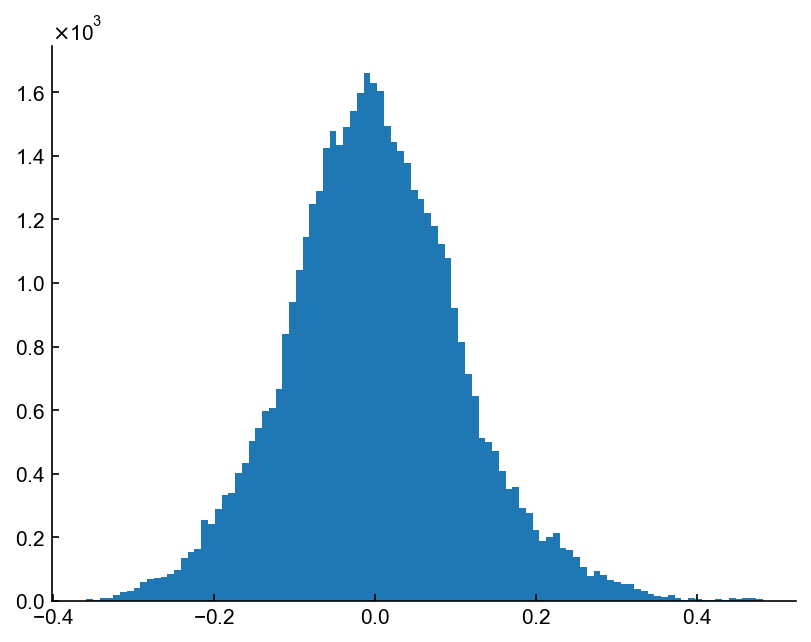

In [27]:
plt.hist(mouth_speed_diff_3003_arr,bins=100)
plt.show()

In [28]:
mouth_fast_3003 = []
for frame_idx,speed in enumerate(speed_Mouth3):
    if frame_idx>video3003_start_frame-1:
        if np.mean(speed_Mouth3[frame_idx:frame_idx+100])-np.mean(speed_Mouth3[frame_idx-100:frame_idx])>mouth_interval1:
            mouth_fast_3003.append(frame_idx)
            
mouth_fast_3003 = np.array(mouth_fast_3003)           
 
print(len(mouth_fast_3003))     
print(mouth_fast_3003)

1549
[  381   382   383 ... 47952 47953 47954]


In [29]:
mouth_fast_3003

array([  381,   382,   383, ..., 47952, 47953, 47954])

In [30]:
threshold = 100
diff_mouth_fast_3003 = np.abs(np.diff(mouth_fast_3003))
mask_mouth_fast_3003 = np.concatenate(([True],(diff_mouth_fast_3003>100)|(diff_mouth_fast_3003==0),[True]))
new_mouth_fast_3003 = mouth_fast_3003[mask_mouth_fast_3003[:-1]]
new_mouth_fast_3003 = new_mouth_fast_3003[:-1]
print(len(new_mouth_fast_3003))
print(new_mouth_fast_3003)

41
[  381  3015  4261  4576  5790  7578  7910  9182 12125 12681 14105 15154
 15839 19271 21241 21852 22071 23899 24122 24651 25888 26366 26585 27152
 27407 28079 28696 29407 29937 30283 31373 35437 36297 37003 37534 38108
 38665 40385 42240 43965 46720]


In [31]:
mouth_3003_movement_onset_samples_arr = []
for frames in new_mouth_fast_3003:
    mouth_3003_movement_onset_samples = move_3003_start_samples[frames]
    mouth_3003_movement_onset_samples_arr.append(mouth_3003_movement_onset_samples)

mouth_3003_movement_onset_samples_arr = np.array(mouth_3003_movement_onset_samples_arr)

print(len(mouth_3003_movement_onset_samples_arr))



41


In [32]:
mouth_3003_movement_onset = np.array(new_mouth_fast_3003)
mouth_3003_window1_start = mouth_3003_movement_onset - 200
mouth_3003_window2_start = mouth_3003_movement_onset - 100
mouth_3003_movement_offset = mouth_3003_movement_onset + 100
mouth_3003_movement_offset2 = mouth_3003_movement_onset + 200

mouth_3003_window_arr = np.zeros((len(mouth_3003_movement_onset),5))
for idx in range(len(mouth_3003_movement_onset)):
    mouth_3003_window_arr[idx][0] = mouth_3003_window1_start[idx]
    mouth_3003_window_arr[idx][1] = mouth_3003_window2_start[idx]
    mouth_3003_window_arr[idx][2] = mouth_3003_movement_onset[idx]
    mouth_3003_window_arr[idx][3] = mouth_3003_movement_offset[idx]
    mouth_3003_window_arr[idx][4] = mouth_3003_movement_offset2[idx]

In [33]:
print(mouth_3003_movement_onset) #units = frames

[  381  3015  4261  4576  5790  7578  7910  9182 12125 12681 14105 15154
 15839 19271 21241 21852 22071 23899 24122 24651 25888 26366 26585 27152
 27407 28079 28696 29407 29937 30283 31373 35437 36297 37003 37534 38108
 38665 40385 42240 43965 46720]


In [34]:
speed_Mouth3[381]

0.7342575270095827

In [35]:
###important function for all body part
def calculate_delta_speed(speed_arr,window1_start,window2_start,movement_onset,movement_offset,movement_offset2):
    speed_mean = np.mean(speed_arr[window1_start:window2_start])
                                   
    delta_speed_arr = []
    for speed in speed_arr[window1_start:movement_offset2]:
        delta_speed = speed #- speed_mean
        delta_speed_arr.append(delta_speed)
        
    delta_speed_arr = np.array(delta_speed_arr)
    #print(delta_speed_arr[200])
    return delta_speed_arr

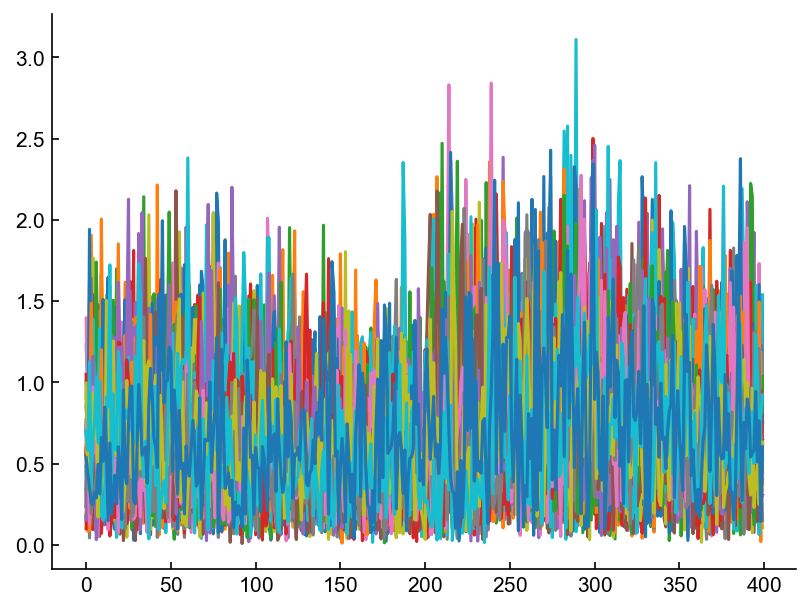

In [36]:
mouth_3003_delta_speed_arr = []
for idx in range(len(mouth_3003_window_arr)):
    delta_speed = calculate_delta_speed(speed_Mouth3,int(mouth_3003_window_arr[idx][0]),int(mouth_3003_window_arr[idx][1]),int(mouth_3003_window_arr[idx][2]),int(mouth_3003_window_arr[idx][3]),int(mouth_3003_window_arr[idx][4]))
    plt.plot(delta_speed)
    mouth_3003_delta_speed_arr.append(delta_speed)



In [37]:
print(len( mouth_3003_delta_speed_arr[0]))
print(len( mouth_3003_delta_speed_arr))

400
41


C:\Users\insan\AppData\Local\Temp\ipykernel_14808\2531204438.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['-200','-150','-100','-50','0','50','100','150','200'])


Text(240, 0.4, 'fast')

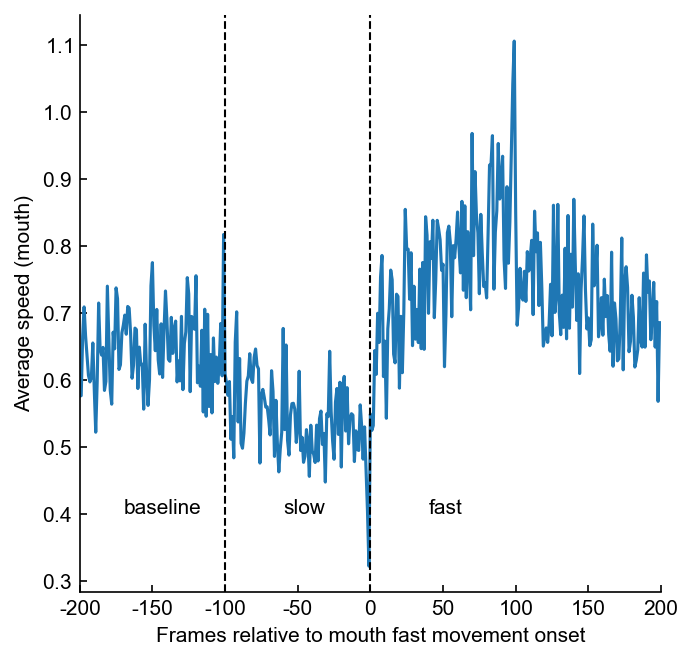

In [38]:
avg_mouth_3003_speed = np.array(mouth_3003_delta_speed_arr)
avg_mouth_3003_speed = np.mean(avg_mouth_3003_speed,axis = 0)

size=5

fig,ax = plt.subplots(figsize=(5,5))
ax.plot(avg_mouth_3003_speed)
ax.set_xlim([0,400])
ax.set_xticklabels(['-200','-150','-100','-50','0','50','100','150','200'])
ax.set_ylabel('Average speed (mouth)')
ax.set_xlabel('Frames relative to mouth fast movement onset')
ax.axvline(100,color='black',linestyle='--',zorder=10,lw=1)
ax.axvline(200,color='black',linestyle='--',zorder=10,lw=1)
ax.text(30,0.4,'baseline')
ax.text(140,0.4,'slow')
ax.text(240,0.4,'fast')
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Movement figures\\Mouth_Movement_3003.png'),transparent=False,facecolor="white")
   

In [39]:
mouth_avg_slow_speed_arr = []
mouth_avg_fast_speed_arr = []
for frame_idx in mouth_3003_movement_onset:
    mouth_avg_slow_speed = np.mean(speed_Mouth3[frame_idx-100:frame_idx])
    mouth_avg_slow_speed_arr.append(mouth_avg_slow_speed)
    mouth_avg_fast_speed = np.mean(speed_Mouth3[frame_idx:frame_idx+100])
    mouth_avg_fast_speed_arr.append(mouth_avg_fast_speed)

mouth_move_speed_period = np.zeros((len(mouth_avg_fast_speed_arr),2))

for idx in range(len(mouth_avg_fast_speed_arr)):
    mouth_move_speed_period[idx][0] = mouth_avg_slow_speed_arr[idx]
    mouth_move_speed_period[idx][1] = mouth_avg_fast_speed_arr[idx]
    
mouth_move_speed_period

array([[0.53814199, 0.75604159],
       [0.59988547, 0.81951117],
       [0.67570082, 0.89954652],
       [0.58018329, 0.80388414],
       [0.63477441, 0.85875271],
       [0.5812129 , 0.81646775],
       [0.56018862, 0.78913722],
       [0.53334468, 0.75398953],
       [0.62179746, 0.84088553],
       [0.6540223 , 0.87938573],
       [0.63154285, 0.86092333],
       [0.65678423, 0.88529406],
       [0.57959933, 0.8184195 ],
       [0.4956931 , 0.71493868],
       [0.53498889, 0.76172883],
       [0.5413558 , 0.76491211],
       [0.60095621, 0.8215851 ],
       [0.49169006, 0.7165866 ],
       [0.45490089, 0.67521868],
       [0.43186581, 0.65192433],
       [0.56488971, 0.787728  ],
       [0.48513598, 0.70772272],
       [0.54321103, 0.76397972],
       [0.47945956, 0.70338211],
       [0.46307374, 0.68547422],
       [0.40016381, 0.62633967],
       [0.53626657, 0.7589382 ],
       [0.55779716, 0.77877664],
       [0.56671857, 0.79327002],
       [0.59923284, 0.82881084],
       [0.

In [40]:
#Whisker

In [41]:
whisker_speed_diff_3003_arr = []
for frame_idx,speed in enumerate(speed_Whisker3):
    if frame_idx>video3003_start_frame-1:
        speed_diff = np.mean(speed_Whisker3[frame_idx:frame_idx+100])-np.mean(speed_Whisker3[frame_idx-100:frame_idx])
        whisker_speed_diff_3003_arr.append(speed_diff)
        
whisker_speed_diff_3003_arr = np.array(whisker_speed_diff_3003_arr)
print(len(whisker_speed_diff_3003_arr))

47850


In [42]:
whisker_speed_3003_std = np.std(whisker_speed_diff_3003_arr)
whisker_speed_3003_mean = np.mean(whisker_speed_diff_3003_arr)
whisker_interval1 = whisker_speed_3003_mean+whisker_speed_3003_std*2
whisker_interval2 = whisker_speed_3003_mean+whisker_speed_3003_std*-2
print(whisker_speed_3003_mean)
print(whisker_interval1)
print(whisker_interval2)

6.087510376365284e-05
0.10794087851800999
-0.10781912831048268


In [43]:
whisker_major_speed = []
for speed in whisker_speed_diff_3003_arr:
    if speed<whisker_interval1 and speed>whisker_interval2:
        whisker_major_speed.append(speed)
        
print(len(whisker_major_speed))
print(45454/47855)

45449
0.9498276042210845


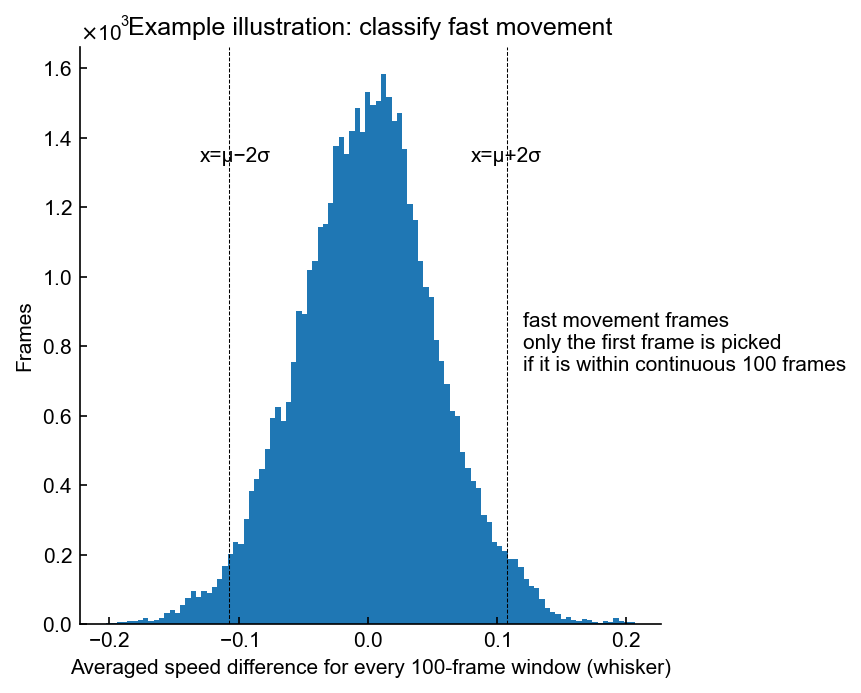

In [44]:

size=5

fig,ax = plt.subplots(figsize=(5,5))
plt.title('Example illustration: classify fast movement')
plt.hist(whisker_speed_diff_3003_arr,bins=100)
plt.xlabel('Averaged speed difference for every 100-frame window (whisker)')
plt.ylabel('Frames')
plt.axvline(whisker_interval2,color='black',linestyle='--',zorder=10,lw=0.5)
plt.axvline(whisker_interval1,color='black',linestyle='--',zorder=10,lw=0.5)
plt.text(-0.13,11**3,'x=μ−2σ')
plt.text(0.08,11**3,'x=μ+2σ')
plt.text(0.12,9**3,'fast movement frames'+'\n'+'only the first frame is picked'+'\n'+'if it is within continuous 100 frames')
plt.show()
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Movement figures\\classify movement example.png'),transparent=False,facecolor="white")

1254
[  417  1475  1476 ... 47899 47900 47901]
48
[  417  1475  3243  4071  4549  5036  5257  6845  7044  7569  7918  9806
 11526 12455 12665 12994 13886 15015 17038 17227 17918 18642 19950 20632
 21246 21505 22834 23100 23509 23902 25554 26338 27145 27831 28653 33359
 34194 35475 35701 36253 37042 38043 39119 39393 39762 40423 42492 43065]
48
[  417  1475  3243  4071  4549  5036  5257  6845  7044  7569  7918  9806
 11526 12455 12665 12994 13886 15015 17038 17227 17918 18642 19950 20632
 21246 21505 22834 23100 23509 23902 25554 26338 27145 27831 28653 33359
 34194 35475 35701 36253 37042 38043 39119 39393 39762 40423 42492 43065]


C:\Users\insan\AppData\Local\Temp\ipykernel_14808\1021524865.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['-200','-150','-100','-50','0','50','100','150','200'])


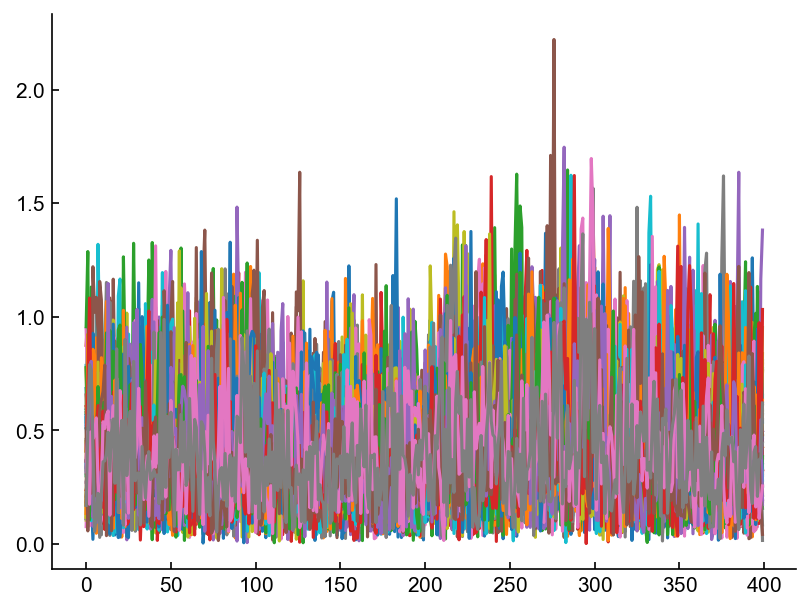

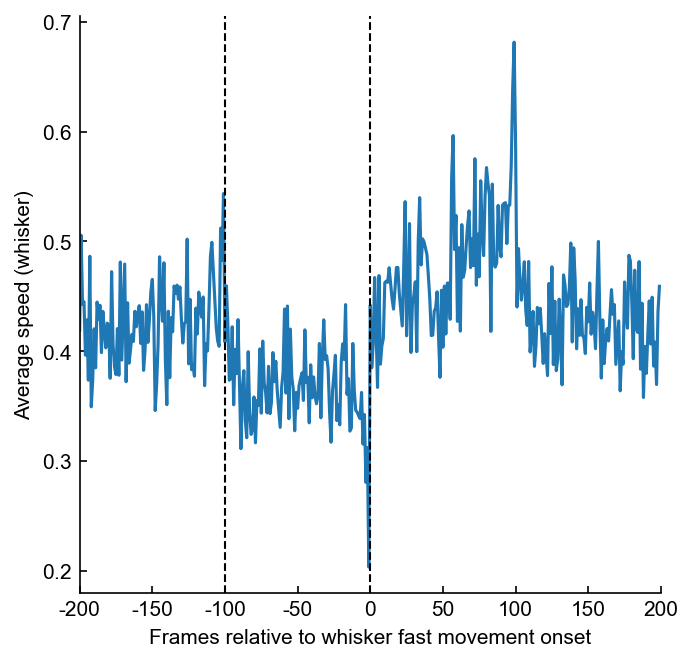

In [45]:
whisker_fast_3003 = []
for frame_idx,speed in enumerate(speed_Whisker3):
    if frame_idx>video3003_start_frame-1:
        if np.mean(speed_Whisker3[frame_idx:frame_idx+100])-np.mean(speed_Whisker3[frame_idx-100:frame_idx])>whisker_interval1:
            whisker_fast_3003.append(frame_idx)
            
whisker_fast_3003 = np.array(whisker_fast_3003)           
 
print(len(whisker_fast_3003))     
print(whisker_fast_3003)

threshold = 100
diff_whisker_fast_3003 = np.abs(np.diff(whisker_fast_3003))
mask_whisker_fast_3003 = np.concatenate(([True],(diff_whisker_fast_3003>100)|(diff_whisker_fast_3003==0),[True]))
new_whisker_fast_3003 = whisker_fast_3003[mask_whisker_fast_3003[:-1]]
new_whisker_fast_3003 = new_whisker_fast_3003[:-1]
print(len(new_whisker_fast_3003))
print(new_whisker_fast_3003)

whisker_3003_movement_onset_samples_arr = []
for frames in new_whisker_fast_3003:
    whisker_3003_movement_onset_samples = move_3003_start_samples[frames]
    whisker_3003_movement_onset_samples_arr.append(whisker_3003_movement_onset_samples)

whisker_3003_movement_onset_samples_arr = np.array(whisker_3003_movement_onset_samples_arr)

print(len(whisker_3003_movement_onset_samples_arr))


whisker_3003_movement_onset = np.array(new_whisker_fast_3003)
whisker_3003_window1_start = whisker_3003_movement_onset - 200
whisker_3003_window2_start = whisker_3003_movement_onset - 100
whisker_3003_movement_offset = whisker_3003_movement_onset + 100
whisker_3003_movement_offset2 = whisker_3003_movement_onset + 200

whisker_3003_window_arr = np.zeros((len(whisker_3003_movement_onset),5))
for idx in range(len(whisker_3003_movement_onset)):
    whisker_3003_window_arr[idx][0] = whisker_3003_window1_start[idx]
    whisker_3003_window_arr[idx][1] = whisker_3003_window2_start[idx]
    whisker_3003_window_arr[idx][2] = whisker_3003_movement_onset[idx]
    whisker_3003_window_arr[idx][3] = whisker_3003_movement_offset[idx]
    whisker_3003_window_arr[idx][4] = whisker_3003_movement_offset2[idx]
    
print(whisker_3003_movement_onset) #units = frames

whisker_3003_delta_speed_arr = []
for idx in range(len(whisker_3003_window_arr)):
    delta_speed = calculate_delta_speed(speed_Whisker3,int(whisker_3003_window_arr[idx][0]),int(whisker_3003_window_arr[idx][1]),int(whisker_3003_window_arr[idx][2]),int(whisker_3003_window_arr[idx][3]),int(whisker_3003_window_arr[idx][4]))
    plt.plot(delta_speed)
    whisker_3003_delta_speed_arr.append(delta_speed)

avg_whisker_3003_speed = np.array(whisker_3003_delta_speed_arr)
avg_whisker_3003_speed = np.mean(avg_whisker_3003_speed,axis = 0)

size=5

fig,ax = plt.subplots(figsize=(5,5))
ax.plot(avg_whisker_3003_speed)
ax.set_xlim([0,400])
ax.set_xticklabels(['-200','-150','-100','-50','0','50','100','150','200'])
ax.set_ylabel('Average speed (whisker)')
ax.set_xlabel('Frames relative to whisker fast movement onset')
ax.axvline(100,color='black',linestyle='--',zorder=10,lw=1)
ax.axvline(200,color='black',linestyle='--',zorder=10,lw=1)
# ax.text(140,0.6,'slow')
# ax.text(240,0.6,'fast')
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Movement figures\\Whisker_Movement_3003.png'),transparent=False,facecolor="white")

In [46]:
#Nose

In [47]:
nose_speed_diff_3003_arr = []
for frame_idx,speed in enumerate(speed_Nose3):
    if frame_idx>video3003_start_frame-1:
        speed_diff = np.mean(speed_Nose3[frame_idx:frame_idx+100])-np.mean(speed_Nose3[frame_idx-100:frame_idx])
        nose_speed_diff_3003_arr.append(speed_diff)
        
nose_speed_diff_3003_arr = np.array(nose_speed_diff_3003_arr)
print(len(nose_speed_diff_3003_arr))

47850


In [48]:
nose_speed_3003_std = np.std(nose_speed_diff_3003_arr)
nose_speed_3003_mean = np.mean(nose_speed_diff_3003_arr)
nose_interval1 = nose_speed_3003_mean+nose_speed_3003_std*2
nose_interval2 = nose_speed_3003_mean+nose_speed_3003_std*2*-1
print(nose_speed_3003_mean)
print(nose_interval1)

0.0002534339015318363
0.1387815545739254


In [49]:
nose_major_speed = []
for speed in nose_speed_diff_3003_arr:
    if speed<nose_interval1 and speed>nose_interval2:
        nose_major_speed.append(speed)
        
print(len(nose_major_speed))
print(46245/47855)

46241
0.9663567025389197


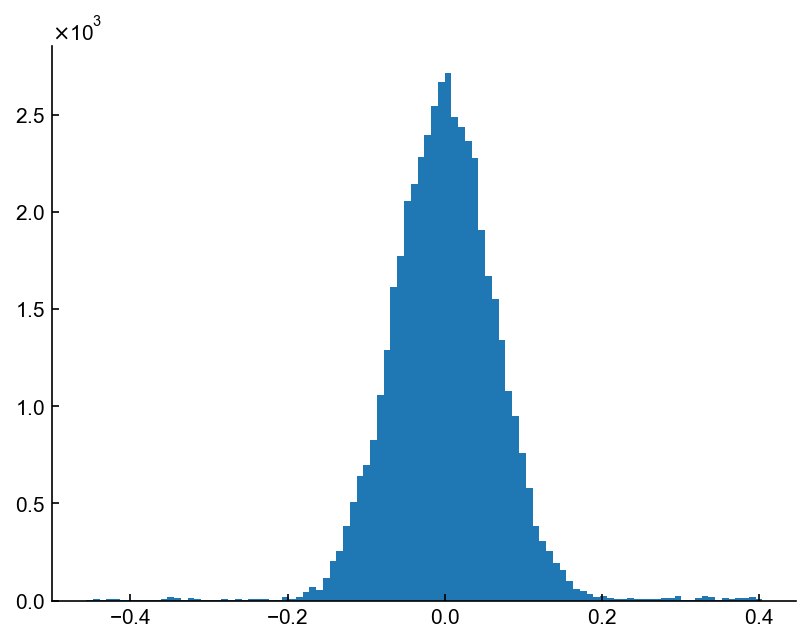

In [50]:
plt.hist(nose_speed_diff_3003_arr,bins=100)
plt.show()

891
[ 4053  4054  4055  4056  4057  4058  4059  4060  4061  4062  4063  4064
  4065  4066  4067  4068  4069  4070  4071  4072  4073  4074  4075  4076
  4077  4078  4079  4080  4081  4082  4083  4084  4085  4086  4087  4088
  4089  4090  4091  4092  4093  4094  4095  4096  4097  4098  4099  4100
  4101  4102  4103  4104  4105  4106  4107  4108  4109  4110  4111  4112
  4113  4114  4115  4116  4117  4118  4119  4120  4121  4122  4123  4124
  4125  4126  4127  4128  4129  4130  4131  4132  4133  4134  4135  4136
  4137  4138  4139  4140  4141  4142  4143  4144  4145  4146  4147  4148
  4149  4150  4151  4152  4759  4760  4763  4766  4767  4768  4769  4770
  4772  6287  6288  6299  6300  6301  6302  6303  6817  6818  6819  6820
  6821  6822  6823  6824  6825  6826  6827  6828  6829  6830  6831  6832
  6833  6834  6835  6836  6837  6839  6840  6842  6843  6844  6845  6846
  6847  6848  6849  6850  6851  6852  6853  6854  6855  6856  6857  6858
  6859  6860  6861  6862  8898  8919  8920  892

C:\Users\insan\AppData\Local\Temp\ipykernel_14808\1911217163.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['-200','-150','-100','-50','0','50','100','150','200'])


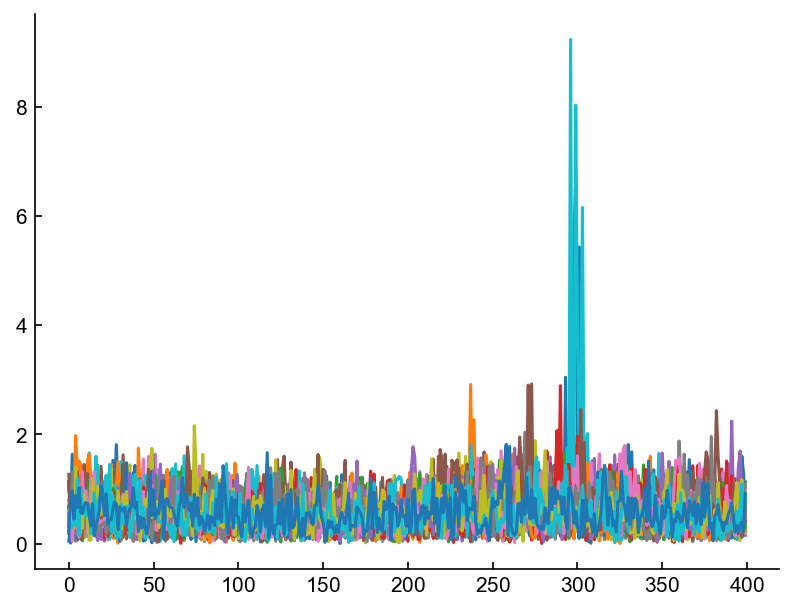

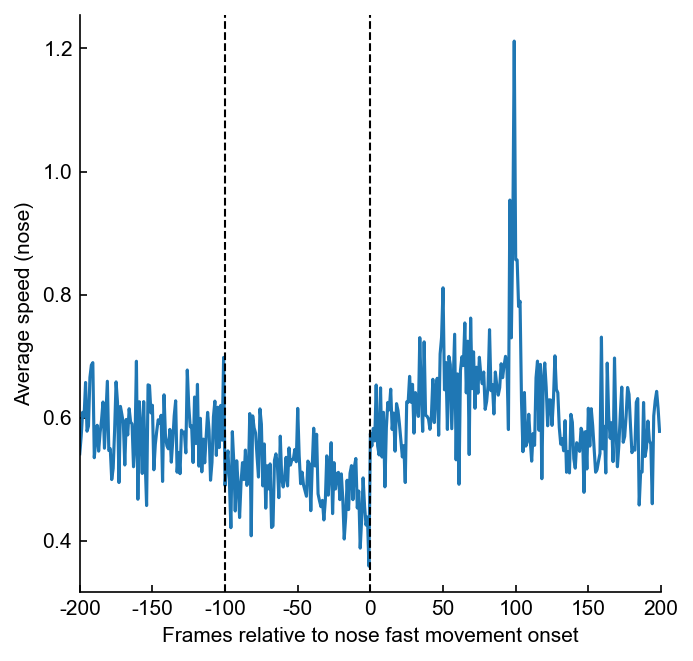

In [51]:
nose_fast_3003 = []
for frame_idx,speed in enumerate(speed_Nose3):
    if frame_idx>video3003_start_frame-1:
        if np.mean(speed_Nose3[frame_idx:frame_idx+100])-np.mean(speed_Nose3[frame_idx-100:frame_idx])>nose_interval1:
            nose_fast_3003.append(frame_idx)
            
nose_fast_3003 = np.array(nose_fast_3003)           
 
print(len(nose_fast_3003))     
print(nose_fast_3003)

threshold = 100
diff_nose_fast_3003 = np.abs(np.diff(nose_fast_3003))
mask_nose_fast_3003 = np.concatenate(([True],(diff_nose_fast_3003>100)|(diff_nose_fast_3003==0),[True]))
new_nose_fast_3003 = nose_fast_3003[mask_nose_fast_3003[:-1]]
new_nose_fast_3003 = new_nose_fast_3003[:-1]
print(len(new_nose_fast_3003))
print(new_nose_fast_3003)

nose_3003_movement_onset_samples_arr = []
for frames in new_nose_fast_3003:
    nose_3003_movement_onset_samples = move_3003_start_samples[frames]
    nose_3003_movement_onset_samples_arr.append(nose_3003_movement_onset_samples)

nose_3003_movement_onset_samples_arr = np.array(nose_3003_movement_onset_samples_arr)

print(len(nose_3003_movement_onset_samples_arr))


nose_3003_movement_onset = np.array(new_nose_fast_3003)
nose_3003_window1_start = nose_3003_movement_onset - 200
nose_3003_window2_start = nose_3003_movement_onset - 100
nose_3003_movement_offset = nose_3003_movement_onset + 100
nose_3003_movement_offset2 = nose_3003_movement_onset + 200

nose_3003_window_arr = np.zeros((len(nose_3003_movement_onset),5))
for idx in range(len(nose_3003_movement_onset)):
    nose_3003_window_arr[idx][0] = nose_3003_window1_start[idx]
    nose_3003_window_arr[idx][1] = nose_3003_window2_start[idx]
    nose_3003_window_arr[idx][2] = nose_3003_movement_onset[idx]
    nose_3003_window_arr[idx][3] = nose_3003_movement_offset[idx]
    nose_3003_window_arr[idx][4] = nose_3003_movement_offset2[idx]
    
print(nose_3003_movement_onset) #units = frames

nose_3003_delta_speed_arr = []
for idx in range(len(nose_3003_window_arr)):
    delta_speed = calculate_delta_speed(speed_Nose3,int(nose_3003_window_arr[idx][0]),int(nose_3003_window_arr[idx][1]),int(nose_3003_window_arr[idx][2]),int(nose_3003_window_arr[idx][3]),int(nose_3003_window_arr[idx][4]))
    plt.plot(delta_speed)
    nose_3003_delta_speed_arr.append(delta_speed)

avg_nose_3003_speed = np.array(nose_3003_delta_speed_arr)
avg_nose_3003_speed = np.mean(avg_nose_3003_speed,axis = 0)

size=5

fig,ax = plt.subplots(figsize=(5,5))
ax.plot(avg_nose_3003_speed)
ax.set_xlim([0,400])
ax.set_xticklabels(['-200','-150','-100','-50','0','50','100','150','200'])
ax.set_ylabel('Average speed (nose)')
ax.set_xlabel('Frames relative to nose fast movement onset')
ax.axvline(100,color='black',linestyle='--',zorder=10,lw=1)
ax.axvline(200,color='black',linestyle='--',zorder=10,lw=1)
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Movement figures\\Nose_3003.png'),transparent=False,facecolor="white")

In [52]:
print(len(nose_3003_movement_onset_samples_arr))
print(len(whisker_3003_movement_onset_samples_arr))
print(len(mouth_3003_movement_onset_samples_arr))

integrate_3003_movement_onset_samples_arr = np.concatenate((mouth_3003_movement_onset_samples_arr,whisker_3003_movement_onset_samples_arr,nose_3003_movement_onset_samples_arr))
len(integrate_3003_movement_onset_samples_arr)

31
48
41


120

In [53]:
#FINAL DON'T DELETE
s3_start_samples

31154001.002311707

In [54]:
move_3003_start_samples

array([31122426.86033249, 31122755.98526001, 31123055.17673492, ...,
       45508674.00884628, 45508973.2003212 , 45509272.377491  ])

In [55]:
sessionfile_D9.meta.files

['February 14 2023 AC Tuning AE_231_3001',
 'February 14 2023 AC Tuning AE_231_3002',
 'February 14 2023 AC Tuning AE_231_3003',
 'February 14 2023 AC Tuning AE_231_3004']

In [56]:
Trial_time_samples = 2.5*30000

In [57]:
np.set_printoptions(suppress=True)

In [58]:
mouth_avg_slow_speed_arr = []
mouth_avg_fast_speed_arr = []
for frame_idx in new_mouth_fast_3003:
    mouth_avg_slow_speed = np.mean(speed_Mouth3[frame_idx-100:frame_idx])
    mouth_avg_slow_speed_arr.append(mouth_avg_slow_speed)
    mouth_avg_fast_speed = np.mean(speed_Mouth3[frame_idx:frame_idx+100])
    mouth_avg_fast_speed_arr.append(mouth_avg_fast_speed)

print(np.mean(speed_Mouth3))
print(np.mean(mouth_avg_slow_speed_arr))
print(np.mean(mouth_avg_fast_speed_arr))

mouth_move_speed_period = np.zeros((len(mouth_avg_fast_speed_arr),2))

for idx in range(len(mouth_avg_fast_speed_arr)):
    mouth_move_speed_period[idx][0] = mouth_avg_slow_speed_arr[idx]
    mouth_move_speed_period[idx][1] = mouth_avg_fast_speed_arr[idx]
    
mouth_move_speed_period

0.6813435210525973
0.542766291117966
0.7666048878008547


array([[0.53814199, 0.75604159],
       [0.59988547, 0.81951117],
       [0.67570082, 0.89954652],
       [0.58018329, 0.80388414],
       [0.63477441, 0.85875271],
       [0.5812129 , 0.81646775],
       [0.56018862, 0.78913722],
       [0.53334468, 0.75398953],
       [0.62179746, 0.84088553],
       [0.6540223 , 0.87938573],
       [0.63154285, 0.86092333],
       [0.65678423, 0.88529406],
       [0.57959933, 0.8184195 ],
       [0.4956931 , 0.71493868],
       [0.53498889, 0.76172883],
       [0.5413558 , 0.76491211],
       [0.60095621, 0.8215851 ],
       [0.49169006, 0.7165866 ],
       [0.45490089, 0.67521868],
       [0.43186581, 0.65192433],
       [0.56488971, 0.787728  ],
       [0.48513598, 0.70772272],
       [0.54321103, 0.76397972],
       [0.47945956, 0.70338211],
       [0.46307374, 0.68547422],
       [0.40016381, 0.62633967],
       [0.53626657, 0.7589382 ],
       [0.55779716, 0.77877664],
       [0.56671857, 0.79327002],
       [0.59923284, 0.82881084],
       [0.

In [59]:
nose_avg_slow_speed_arr = []
nose_avg_fast_speed_arr = []
for frame_idx in new_nose_fast_3003:
    nose_avg_slow_speed = np.mean(speed_Nose3[frame_idx-100:frame_idx])
    nose_avg_slow_speed_arr.append(nose_avg_slow_speed)
    nose_avg_fast_speed = np.mean(speed_Nose3[frame_idx:frame_idx+100])
    nose_avg_fast_speed_arr.append(nose_avg_fast_speed)

print(np.mean(speed_Nose3))
print(np.mean(nose_avg_slow_speed_arr))
print(np.mean(nose_avg_fast_speed_arr))

nose_move_speed_period = np.zeros((len(nose_avg_fast_speed_arr),2))

for idx in range(len(nose_avg_fast_speed_arr)):
    nose_move_speed_period[idx][0] = nose_avg_slow_speed_arr[idx]
    nose_move_speed_period[idx][1] = nose_avg_fast_speed_arr[idx]
    
nose_move_speed_period

0.5661642779926623
0.5018170492706018
0.645585667097199


array([[0.55692696, 0.70569267],
       [0.51431372, 0.66472678],
       [0.48182448, 0.62662955],
       [0.50073361, 0.64286194],
       [0.45052581, 0.58947516],
       [0.47903872, 0.62295471],
       [0.47007314, 0.61065295],
       [0.45979687, 0.60089385],
       [0.51182747, 0.65206112],
       [0.61565783, 0.79732397],
       [0.47671865, 0.61919415],
       [0.50301759, 0.64961994],
       [0.52050107, 0.66148503],
       [0.49337123, 0.63640816],
       [0.50497374, 0.64571152],
       [0.51899872, 0.66449715],
       [0.47902018, 0.62330259],
       [0.46784912, 0.6079893 ],
       [0.59590921, 0.73631355],
       [0.51828103, 0.65789086],
       [0.4331375 , 0.57869921],
       [0.45608277, 0.59501409],
       [0.49992168, 0.63999789],
       [0.48066193, 0.62080681],
       [0.48700402, 0.62932607],
       [0.60458106, 0.74703104],
       [0.49063846, 0.63818625],
       [0.56392655, 0.70402048],
       [0.49017196, 0.63184274],
       [0.44113149, 0.58119709],
       [0.

In [60]:
whisker_avg_slow_speed_arr = []
whisker_avg_fast_speed_arr = []
for frame_idx in new_whisker_fast_3003:
    whisker_avg_slow_speed = np.mean(speed_Whisker3[frame_idx-100:frame_idx])
    whisker_avg_slow_speed_arr.append(whisker_avg_slow_speed)
    whisker_avg_fast_speed = np.mean(speed_Whisker3[frame_idx:frame_idx+100])
    whisker_avg_fast_speed_arr.append(whisker_avg_fast_speed)
    
print(np.mean(speed_Whisker3))
print(np.mean(whisker_avg_slow_speed_arr))
print(np.mean(whisker_avg_fast_speed_arr))
whisker_move_speed_period = np.zeros((len(whisker_avg_fast_speed_arr),2))

for idx in range(len(whisker_avg_fast_speed_arr)):
    whisker_move_speed_period[idx][0] = whisker_avg_slow_speed_arr[idx]
    whisker_move_speed_period[idx][1] = whisker_avg_fast_speed_arr[idx]
    
whisker_move_speed_period

0.41810891296088165
0.3666217155660025
0.47802033996540866


array([[0.38240609, 0.49093359],
       [0.42191343, 0.53190881],
       [0.37245508, 0.48345912],
       [0.36684037, 0.48136463],
       [0.32468744, 0.43339463],
       [0.38034287, 0.48885758],
       [0.37531757, 0.49280672],
       [0.41777214, 0.53479516],
       [0.46400091, 0.57340406],
       [0.38238307, 0.49189685],
       [0.34870157, 0.46048724],
       [0.36257978, 0.47246398],
       [0.41029988, 0.52409773],
       [0.3629769 , 0.47707156],
       [0.41690424, 0.52536987],
       [0.4441154 , 0.55501671],
       [0.41240456, 0.52579657],
       [0.33159937, 0.44636741],
       [0.35652338, 0.4670317 ],
       [0.39282781, 0.5035672 ],
       [0.34005086, 0.44853684],
       [0.36797261, 0.47672435],
       [0.36216322, 0.47241204],
       [0.35945399, 0.46980474],
       [0.38268233, 0.49608482],
       [0.39088361, 0.50434126],
       [0.37340986, 0.48143123],
       [0.31080771, 0.41891154],
       [0.31018578, 0.4195761 ],
       [0.32636348, 0.43811881],
       [0.

In [61]:
#Investigate modulation(tone and reward) on CR
tone_time = sessionfile_D9.trials.starts

mouth_tone_stimulus = []
for movementonset in mouth_3003_movement_onset_samples_arr:
    stimulus_check_window_start = movementonset - 30000
    stimulus_check_window_end = movementonset + 30000

    for stimulus_time in tone_time:
        if stimulus_time <=stimulus_check_window_end and stimulus_time >=stimulus_check_window_start:
            mouth_tone_stimulus.append(stimulus_time)

mouth_tone_stimulus = np.array(mouth_tone_stimulus)

In [62]:
mouth_tone_stimulus

array([32887098., 33414881., 33516897., 34951827., 35377432., 35896116.,
       36879055., 37676474., 37768910., 38314542., 40126563., 40227557.,
       40560305., 41780692., 41982221., 42253133., 42353999., 42574803.,
       43816681., 44340877., 45148553.])

In [63]:
def getStimulusTime(movementonset_samples,stimulus_arr):
    stimulus_to_draw_arr = []
    for movementonset in movementonset_samples:
        stimulus_check_window_start = movementonset - 30000
        stimulus_check_window_end = movementonset + 30000
     
        for stimulus_time in stimulus_arr:
            if stimulus_time <=stimulus_check_window_end and stimulus_time >=stimulus_check_window_start:
                stimulus = stimulus_time - movementonset
                stimulus_to_draw_arr.append(stimulus)
                
    stimulus_to_draw_arr = np.array(stimulus_to_draw_arr)
    
    return stimulus_to_draw_arr

In [64]:
mouth_tone = getStimulusTime(mouth_3003_movement_onset_samples_arr,tone_time)
nose_tone = getStimulusTime(nose_3003_movement_onset_samples_arr,tone_time)
whisker_tone = getStimulusTime(whisker_3003_movement_onset_samples_arr,tone_time)

In [65]:
mouth_tone

array([ 27095.97821045,  18466.92987061,  20895.88515472,  24533.17246628,
        22935.09658051,  21401.70413589, -25233.41590881,  -2111.15262604,
        24618.63723755,  21844.99472809,  22472.65032578,  19657.37946701,
        25403.37388992,  26594.61220932, -29873.38800812,  29239.46486282,
       -29181.45854568,  19397.72894669,  21688.9202652 ,  28388.95430756,
         9550.70069122])

In [66]:
mouth_reward = getStimulusTime(mouth_3003_movement_onset_samples_arr,reward_time)
nose_reward = getStimulusTime(nose_3003_movement_onset_samples_arr,reward_time)
whisker_reward = getStimulusTime(whisker_3003_movement_onset_samples_arr,reward_time)

In [67]:
mouth_reward

array([24684.92987061, 29217.09658051, 27653.70413589, 27967.99472809,
       28796.65032578, 25748.37946701, 25518.72894669, 27802.9202652 ,
       15853.70069122])

In [68]:
print(len(mouth_reward))

9


In [69]:
#Individual cell plots for both NCR and CR

In [70]:
def CalculateforRasterPSTH(movementsToPlots):
    #Raster
    moveSpikes = []
    for movement in movementsToPlots:
        this_move_spike = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=movement-33000, endtime=movement+33000)
        moveSpikes.append(this_move_spike-movement)
    moveSpikes = np.array(moveSpikes,dtype='object') 
    #PSTH
    bw_scott_factor = 3
    starttime = -30000 #samples
    endtime = starttime+60000 #samples
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan) 
    kf = KFold(n_splits=10)

    for idx,(move_index,_) in enumerate(kf.split(moveSpikes)):
        PSTHspikes = np.concatenate(moveSpikes[move_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(move_index) *30000 #convert unit to seconds from samples
    avg_FR = np.mean(FR,axis=0)
    sem_FR = np.std(FR,axis=0)

    max_FR_value = np.max(avg_FR+sem_FR) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    
    return avg_FR,sem_FR,xrange,limit,moveSpikes

def CalculateforRasterPSTHLimit(sessionfile_D9,clust,movementsToPlots):
    #Raster
    moveSpikes = []
    for movement in movementsToPlots:
        this_move_spike = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=movement-33000, endtime=movement+33000)
        moveSpikes.append(this_move_spike-movement)
    moveSpikes = np.array(moveSpikes,dtype='object') 
    #PSTH
    bw_scott_factor = 3
    starttime = -30000 #samples
    endtime = starttime+60000 #samples
    xrange = np.linspace(starttime,endtime,num=1000)
    FR = np.full((10,len(xrange)),np.nan) 
    kf = KFold(n_splits=10)

    for idx,(move_index,_) in enumerate(kf.split(moveSpikes)):
        PSTHspikes = np.concatenate(moveSpikes[move_index])
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(move_index) *30000 #convert unit to seconds from samples
    avg_FR = np.mean(FR,axis=0)
    sem_FR = np.std(FR,axis=0)

    max_FR_value = np.max(avg_FR+sem_FR) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    
    return limit

integrate_limit_arr = []
mouth_limit_arr = []
nose_limit_arr = []
whisker_limit_arr = []
for clust in NCR_D9:
    integrate_limit = CalculateforRasterPSTHLimit(sessionfile_D9,clust,integrate_3003_movement_onset_samples_arr)
    integrate_limit_arr.append(integrate_limit)
 
    mouth_limit = CalculateforRasterPSTHLimit(sessionfile_D9,clust, mouth_3003_movement_onset_samples_arr)
    mouth_limit_arr.append(mouth_limit)
    
    nose_limit = CalculateforRasterPSTHLimit(sessionfile_D9,clust, nose_3003_movement_onset_samples_arr)
    nose_limit_arr.append(nose_limit)
    
    whisker_limit = CalculateforRasterPSTHLimit(sessionfile_D9,clust,whisker_3003_movement_onset_samples_arr)
    whisker_limit_arr.append(whisker_limit)

integrate_limit_arr=np.array(integrate_limit_arr)
mouth_limit_arr = np.array(mouth_limit_arr)
nose_limit_arr = np.array(nose_limit_arr)
whisker_limit_arr = np.array(whisker_limit_arr)
limit_arr = np.concatenate((integrate_limit_arr,mouth_limit_arr,nose_limit_arr,whisker_limit_arr))

In [71]:
def visualizeClusterMovement(sessionfile,clust,limit_arr,celltype):
    movementsToPlots = [integrate_3003_movement_onset_samples_arr,mouth_3003_movement_onset_samples_arr,
                   nose_3003_movement_onset_samples_arr,whisker_3003_movement_onset_samples_arr]

    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    FRmod_color = NCR_CR_cmap( (FRmod-1)/5)
    #########################################################################################
    region = sessionfile.meta.region
    #########################################################################################

    fig = plt.figure(figsize=(15,5))
    fig.suptitle(celltype+' '+str(clust) +' '+ 'from AE_231_3_AC')
    
    gs = fig.add_gridspec(2,4,height_ratios=[0.6,0.4],hspace=0.1)
    
    #Integrate
    ax2 = plt.subplot(gs[1,0])#PSTH
    ax1 = plt.subplot(gs[0,0],sharex=ax2)#Raster
    
    #Mouth
    ax4 = plt.subplot(gs[1,1],sharey=ax2)#PSTH
    ax3 = plt.subplot(gs[0,1],sharex=ax4)#Raster
    
    #Nose
    ax6 = plt.subplot(gs[1,2],sharey=ax2)#PSTH
    ax5 = plt.subplot(gs[0,2],sharex=ax6)#Raster
    
    #Whisker
    ax8 = plt.subplot(gs[1,3],sharey=ax2)#PSTH
    ax7 = plt.subplot(gs[0,3],sharex=ax8)#Raster
    
    
    ax_Raster = [ax3,ax5,ax7]
    ax_PSTH = [ax4,ax6,ax8]
    ################    
    #Raster
    for ax in ax_Raster:
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.axvspan(-30000,0, ymin=0,color='white', alpha=0.3, lw=0,label='slow movement') 
        ax.axvspan(0, 30000, ymin=0,color='lightgray', alpha=0.3, lw=0,label='fast movement') 
    
    ax7.legend(frameon=True,loc=(1.05,0.8))
        
    moveSpikes_Integrate = CalculateforRasterPSTH(movementsToPlots[0])[4]
    for idx,move in enumerate(movementsToPlots[0]):
        ax1.scatter(moveSpikes_Integrate[idx],np.ones_like(moveSpikes_Integrate[idx])*idx,color=FRmod_color,s=1.5,marker='o',lw=0,alpha=0)
    #ax1.annotate('movements = '+str(len(moveSpikes_Integrate)), xy=(0, 1.02), xycoords='axes fraction', xytext=(0, 1.02),color='black')
    
    moveSpikes_Mouth = CalculateforRasterPSTH(movementsToPlots[1])[4]
    for idx,move in enumerate(movementsToPlots[1]):
        ax3.scatter(moveSpikes_Mouth[idx],np.ones_like(moveSpikes_Mouth[idx])*idx,color=FRmod_color,s=1.5,marker='o',lw=0)
    ax3.annotate('movements = '+str(len(moveSpikes_Mouth)), xy=(0, 1.02), xycoords='axes fraction', xytext=(0, 1.02),color='black')
    
    moveSpikes_Nose = CalculateforRasterPSTH(movementsToPlots[2])[4]
    for idx,move in enumerate(movementsToPlots[2]):
        ax5.scatter(moveSpikes_Nose[idx],np.ones_like(moveSpikes_Nose[idx])*idx,color=FRmod_color,s=1.5,marker='o',lw=0)
    ax5.annotate('movements = '+str(len(moveSpikes_Nose)), xy=(0, 1.02), xycoords='axes fraction', xytext=(0, 1.02),color='black')
    
    moveSpikes_Whisker = CalculateforRasterPSTH(movementsToPlots[3])[4]
    for idx,move in enumerate(movementsToPlots[3]):
        ax7.scatter(moveSpikes_Whisker[idx],np.ones_like(moveSpikes_Whisker[idx])*idx,color=FRmod_color,s=1.5,marker='o',lw=0)
    ax7.annotate('movements = '+str(len(moveSpikes_Whisker)), xy=(0, 1.02), xycoords='axes fraction', xytext=(0, 1.02),color='black')
    

    #PSTH
    avg_FR_Integrate = CalculateforRasterPSTH(movementsToPlots[0])[0]
    sem_FR_Integrate = CalculateforRasterPSTH(movementsToPlots[0])[1]
    xrange_Integrate = CalculateforRasterPSTH(movementsToPlots[0])[2]
    limit_Integrate = CalculateforRasterPSTH(movementsToPlots[0])[3]
    ax2.plot(xrange_Integrate,avg_FR_Integrate,lw=1,color=FRmod_color,alpha=0)
    #ax2.fill_between(xrange_Integrate,avg_FR_Integrate-sem_FR_Integrate,avg_FR_Integrate+sem_FR_Integrate,color=FRmod_color,alpha=0.5,zorder=-10,lw=0)
    ax2.set_xlabel('Time relative to all movement onset (s)')
    
    avg_FR_Mouth = CalculateforRasterPSTH(movementsToPlots[1])[0]
    sem_FR_Mouth = CalculateforRasterPSTH(movementsToPlots[1])[1]
    xrange_Mouth = CalculateforRasterPSTH(movementsToPlots[1])[2]
    limit_Mouth = CalculateforRasterPSTH(movementsToPlots[1])[3]
    ax4.plot(xrange_Mouth,avg_FR_Mouth,lw=1,color=FRmod_color)
    ax4.fill_between(xrange_Mouth,avg_FR_Mouth-sem_FR_Mouth,avg_FR_Mouth+sem_FR_Mouth,color=FRmod_color,alpha=0.5,zorder=-10,lw=0)
    ax4.set_xlabel('Time relative to mouth movement onset (s)')
    
    avg_FR_Nose = CalculateforRasterPSTH(movementsToPlots[2])[0]
    sem_FR_Nose = CalculateforRasterPSTH(movementsToPlots[2])[1]
    xrange_Nose = CalculateforRasterPSTH(movementsToPlots[2])[2]
    limit_Nose = CalculateforRasterPSTH(movementsToPlots[2])[3]
    ax6.plot(xrange_Nose,avg_FR_Nose,lw=1,color=FRmod_color)
    ax6.fill_between(xrange_Nose,avg_FR_Nose-sem_FR_Nose,avg_FR_Nose+sem_FR_Nose,color=FRmod_color,alpha=0.5,zorder=-10,lw=0)
    ax6.set_xlabel('Time relative to nose movement onset (s)')
    
    avg_FR_Whisker = CalculateforRasterPSTH(movementsToPlots[3])[0]
    sem_FR_Whisker = CalculateforRasterPSTH(movementsToPlots[3])[1]
    xrange_Whisker = CalculateforRasterPSTH(movementsToPlots[3])[2]
    limit_Whisker = CalculateforRasterPSTH(movementsToPlots[3])[3]
    ax8.plot(xrange_Whisker,avg_FR_Whisker,lw=1,color=FRmod_color)
    ax8.fill_between(xrange_Whisker,avg_FR_Whisker-sem_FR_Whisker,avg_FR_Whisker+sem_FR_Whisker,color=FRmod_color,alpha=0.5,zorder=-10,lw=0)
    ax8.set_xlabel('Time relative to whisker movement onset (s)')
    

    highest_limit = np.max(limit_arr)

    ax2.set_ylim([0,highest_limit])
    ax2.set_yticks([0,highest_limit/2,highest_limit])
    ax2.set_yticklabels(['0',str(int(highest_limit/2)),str(highest_limit)])
    
    
    for ax in ax_PSTH:
        ax.axvspan(0, 33000, ymin=0,color='lightgray', alpha=0.3, lw=0)
        ax.set_ylabel('Firing rate (spikes/s)')
        ax.set_xlim([-30000,30000])
        ax.set_xticks([-30000,-15000,0,15000, 30000])
        ax.set_xticklabels(['-1','-0.5','0','0.5','1'])
        
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    
    
    return fig

meta NOT subset; don't know how to subset; dropped


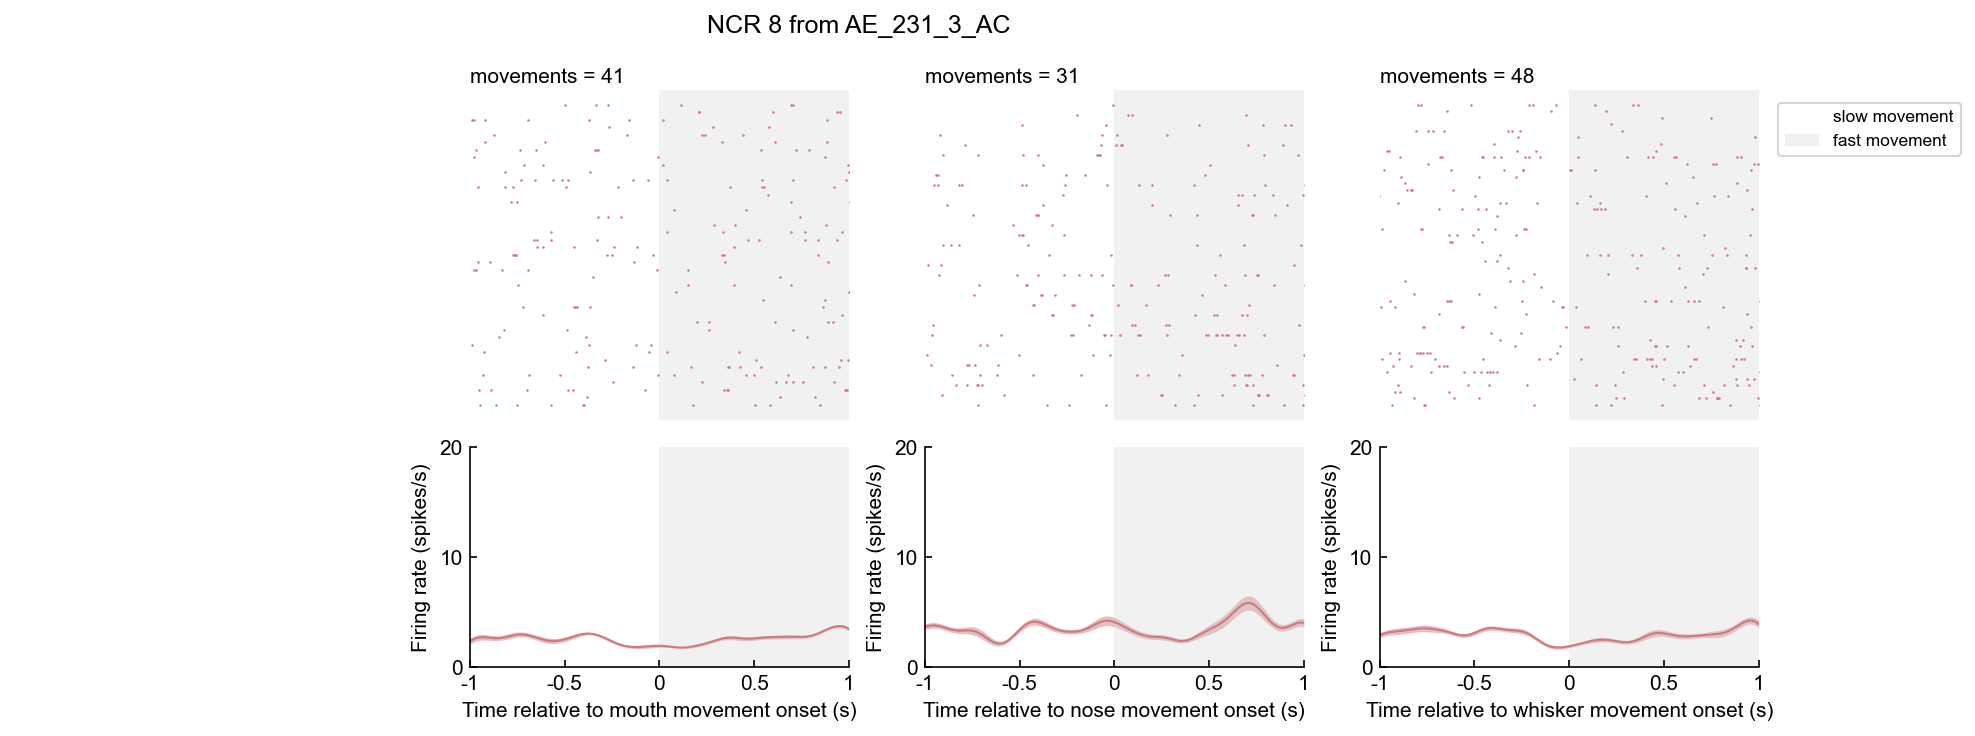

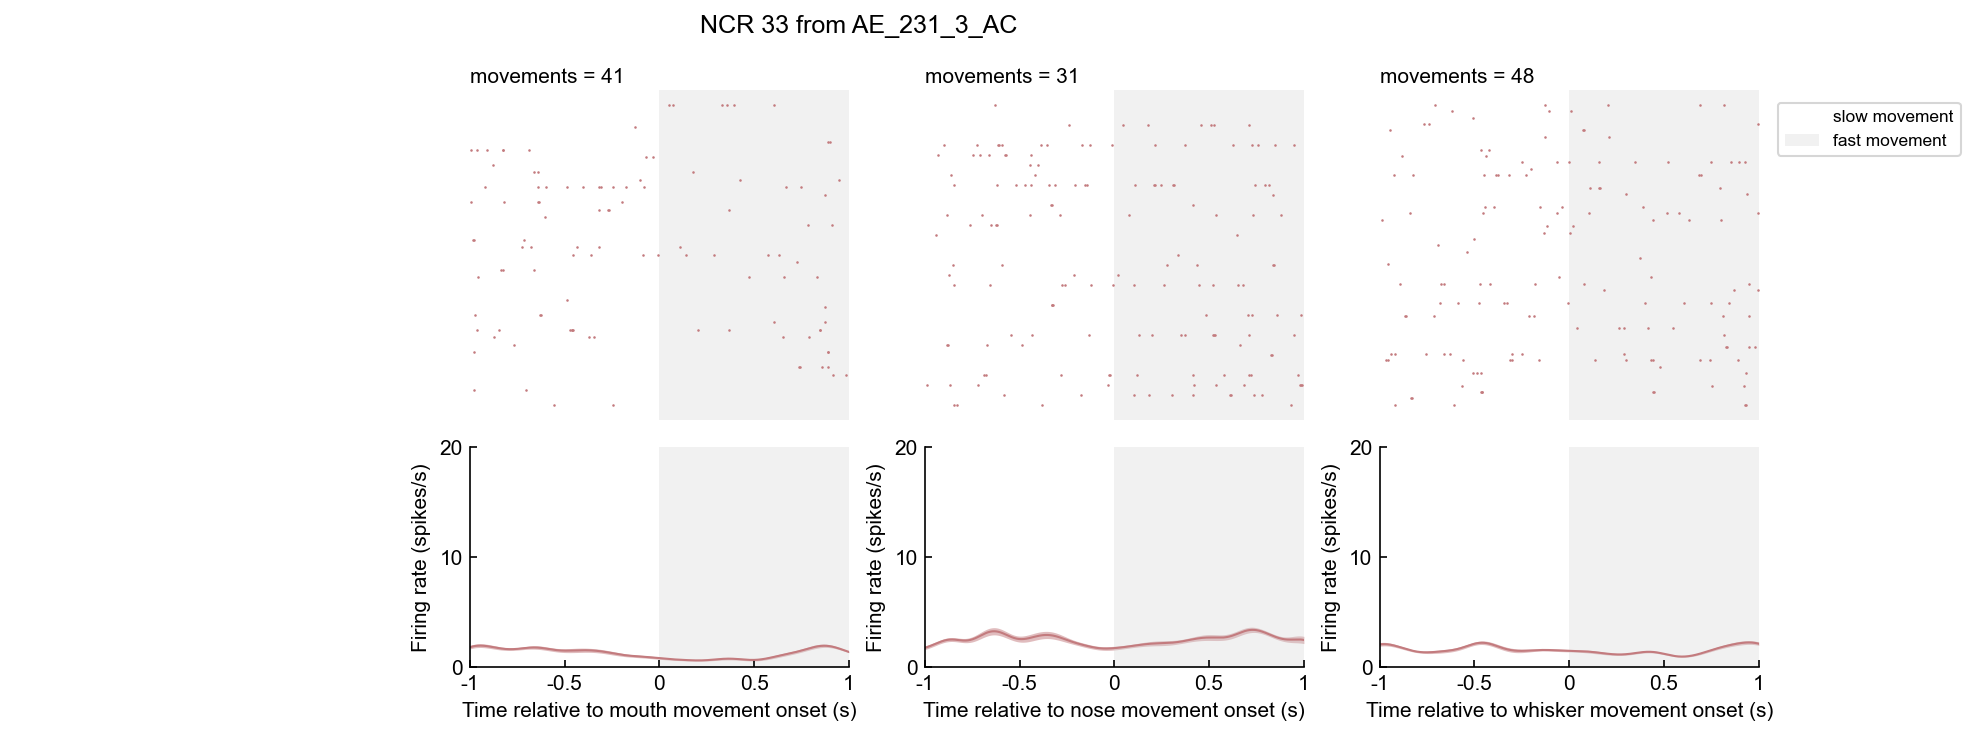

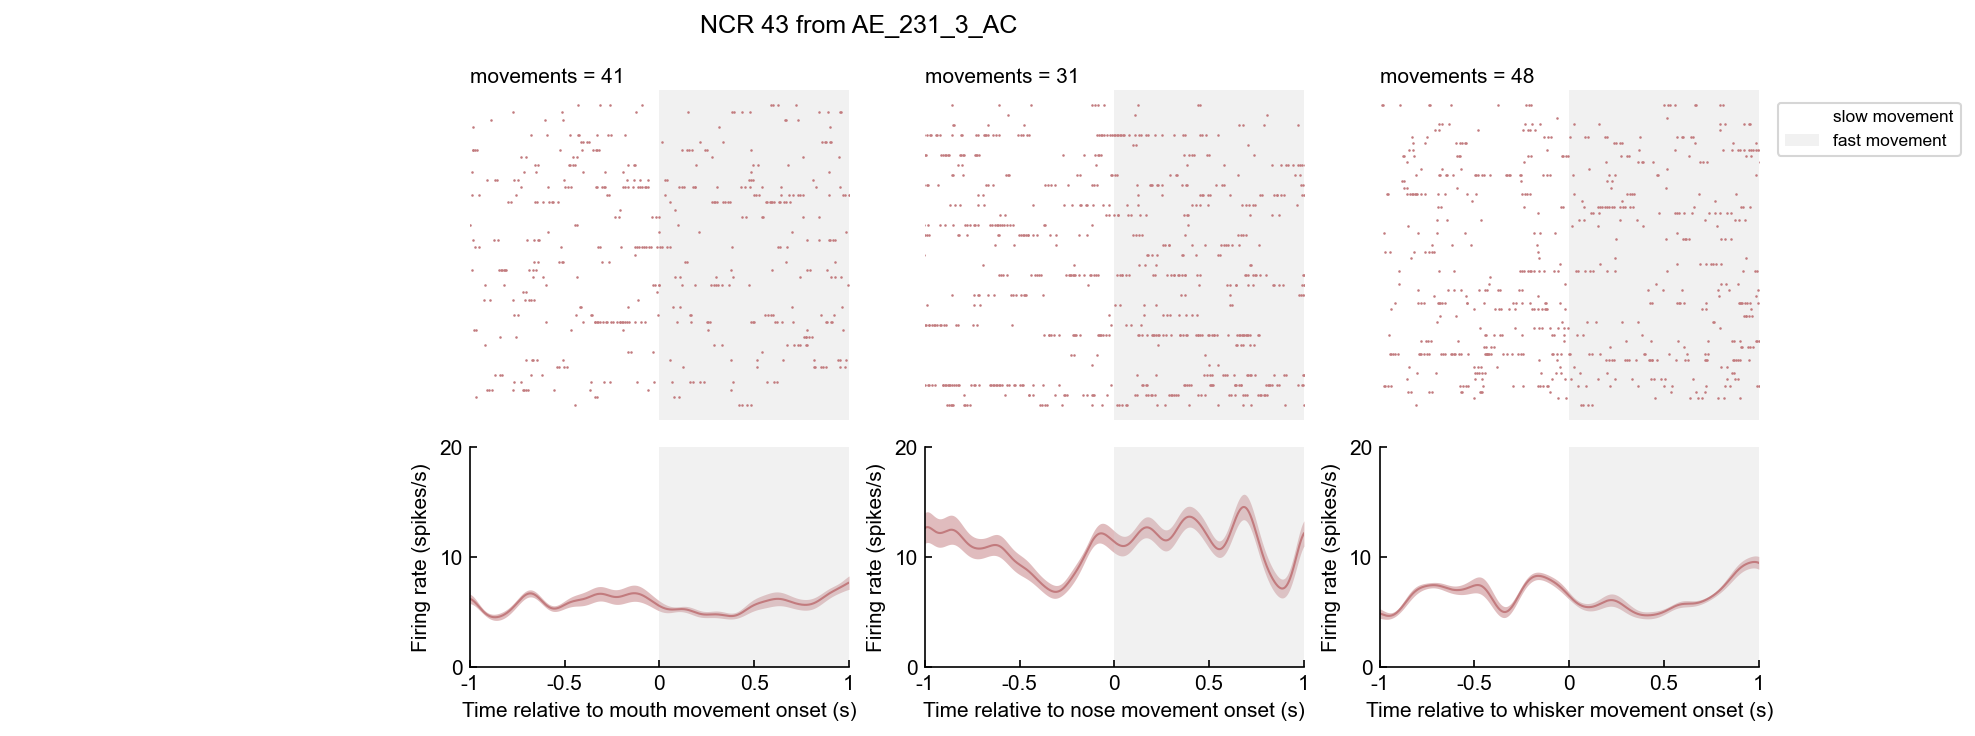

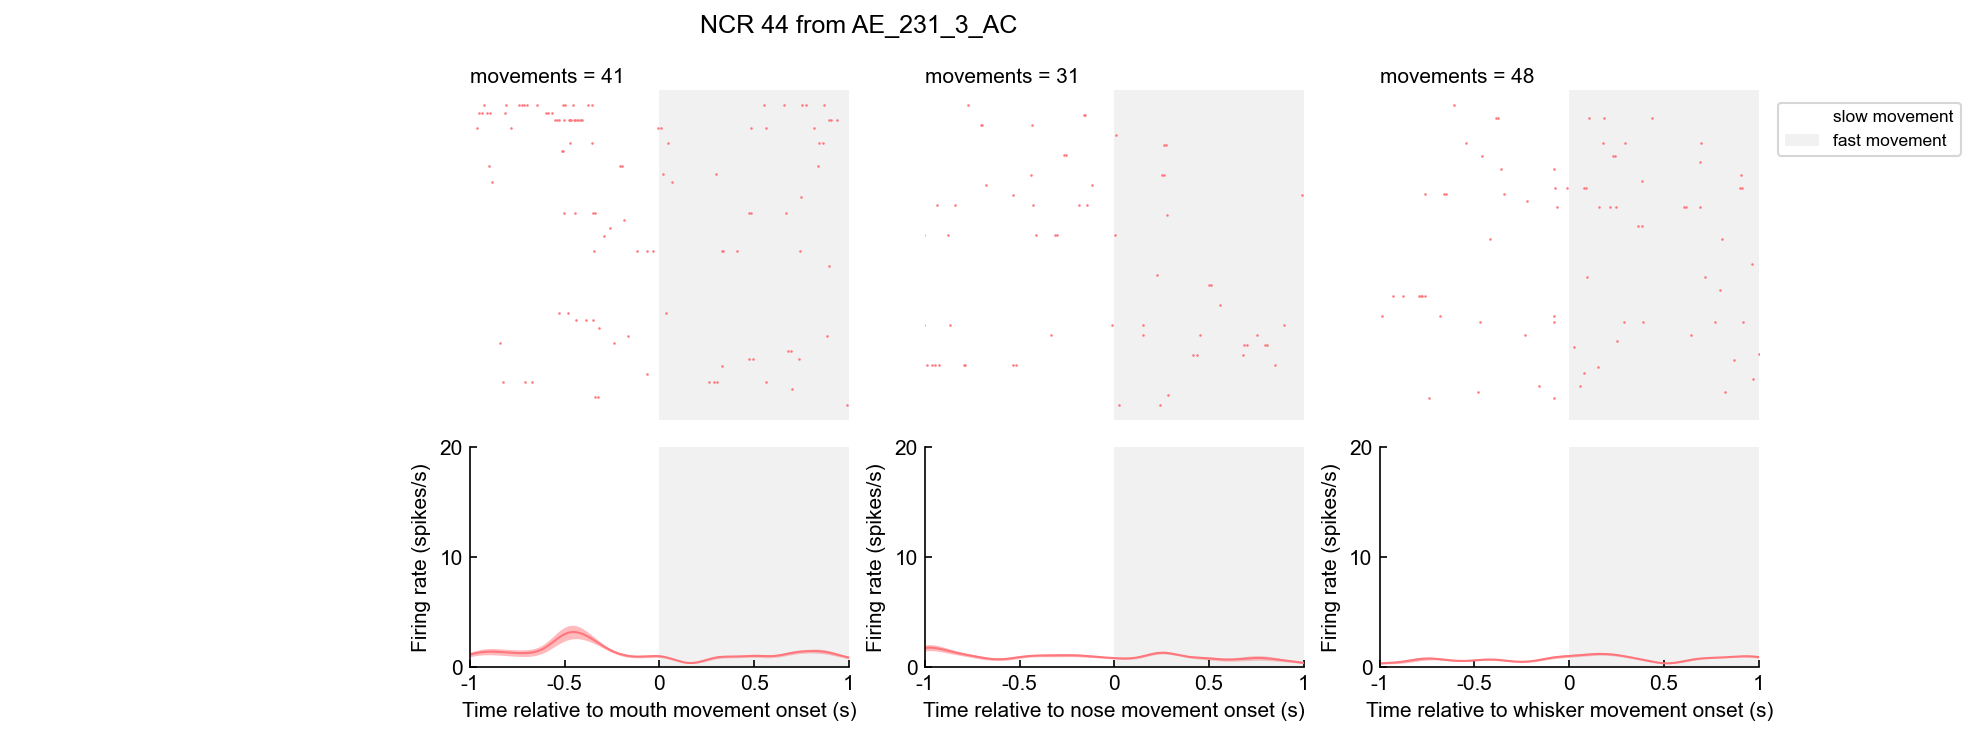

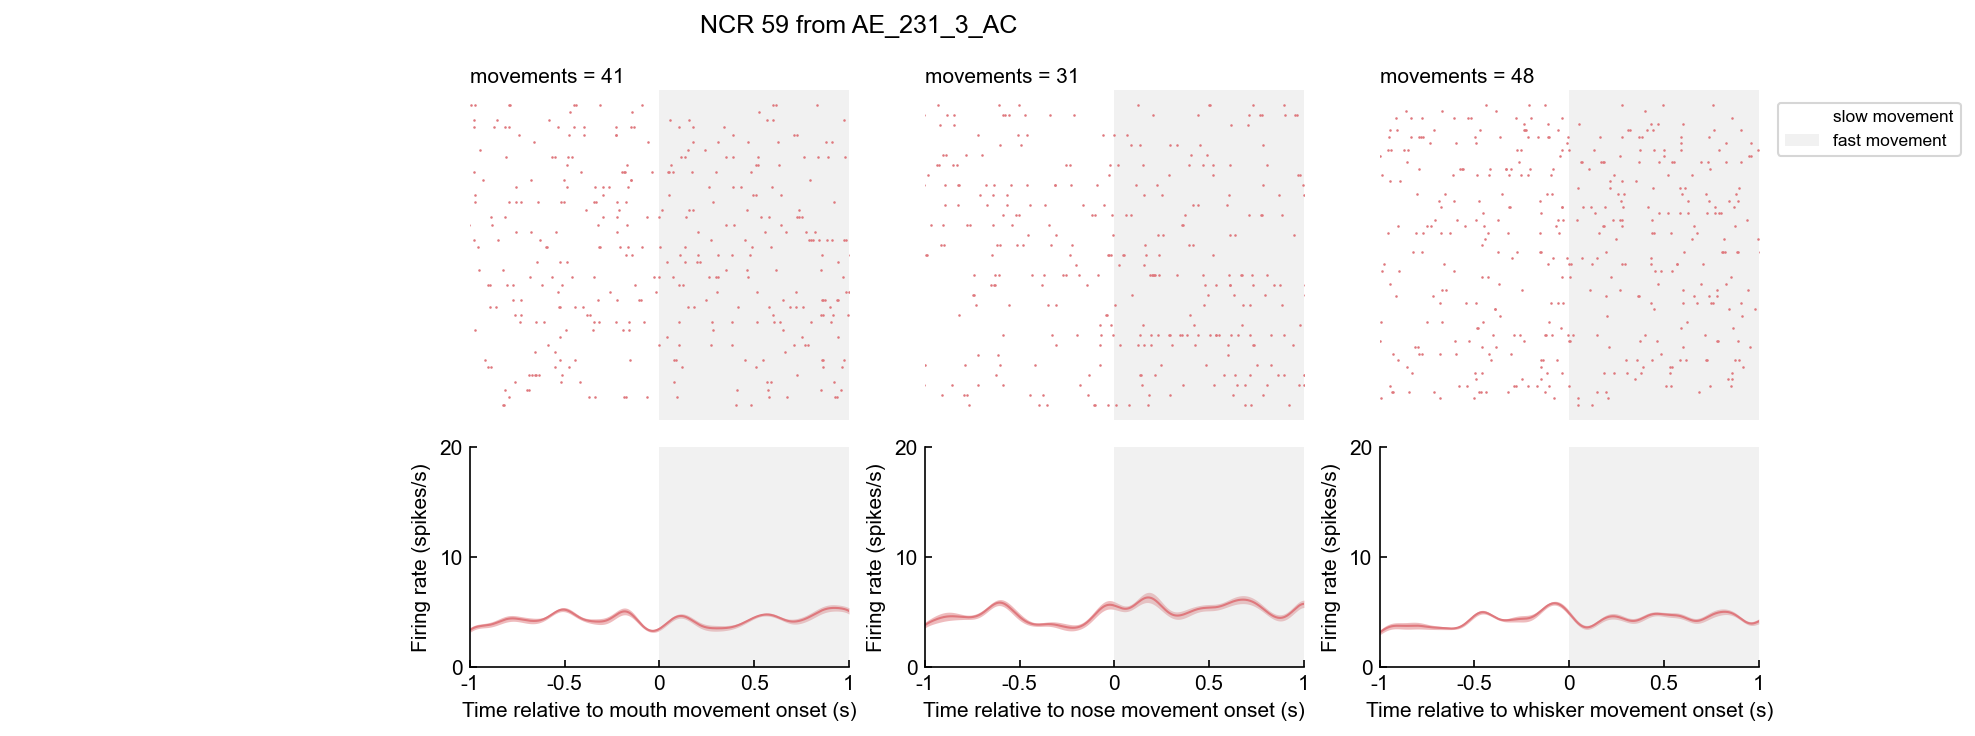

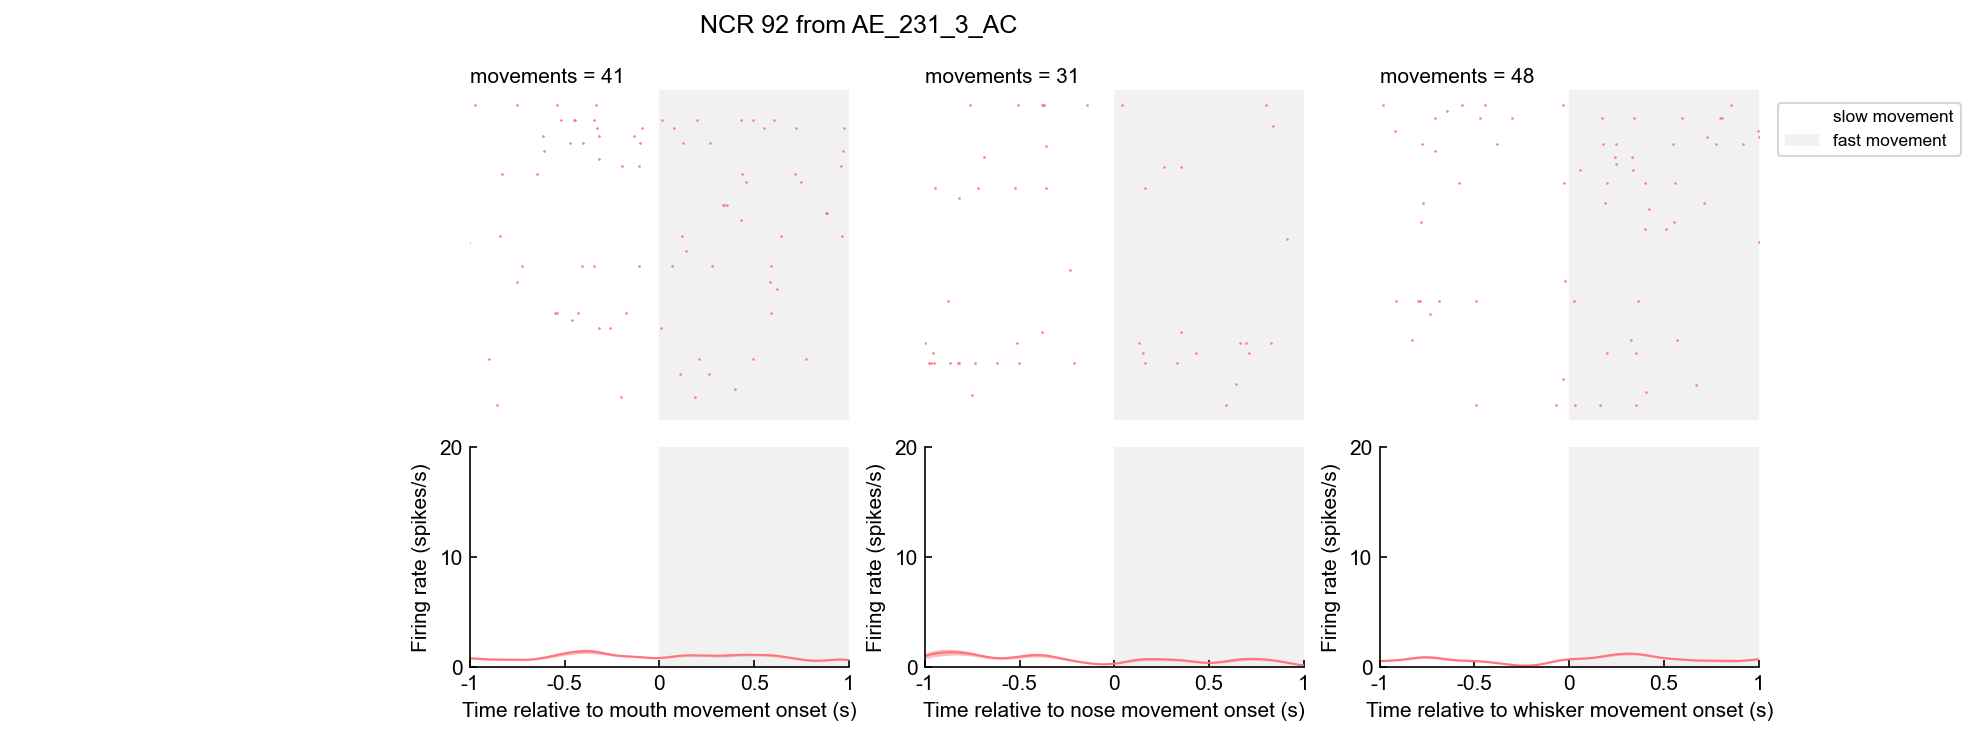

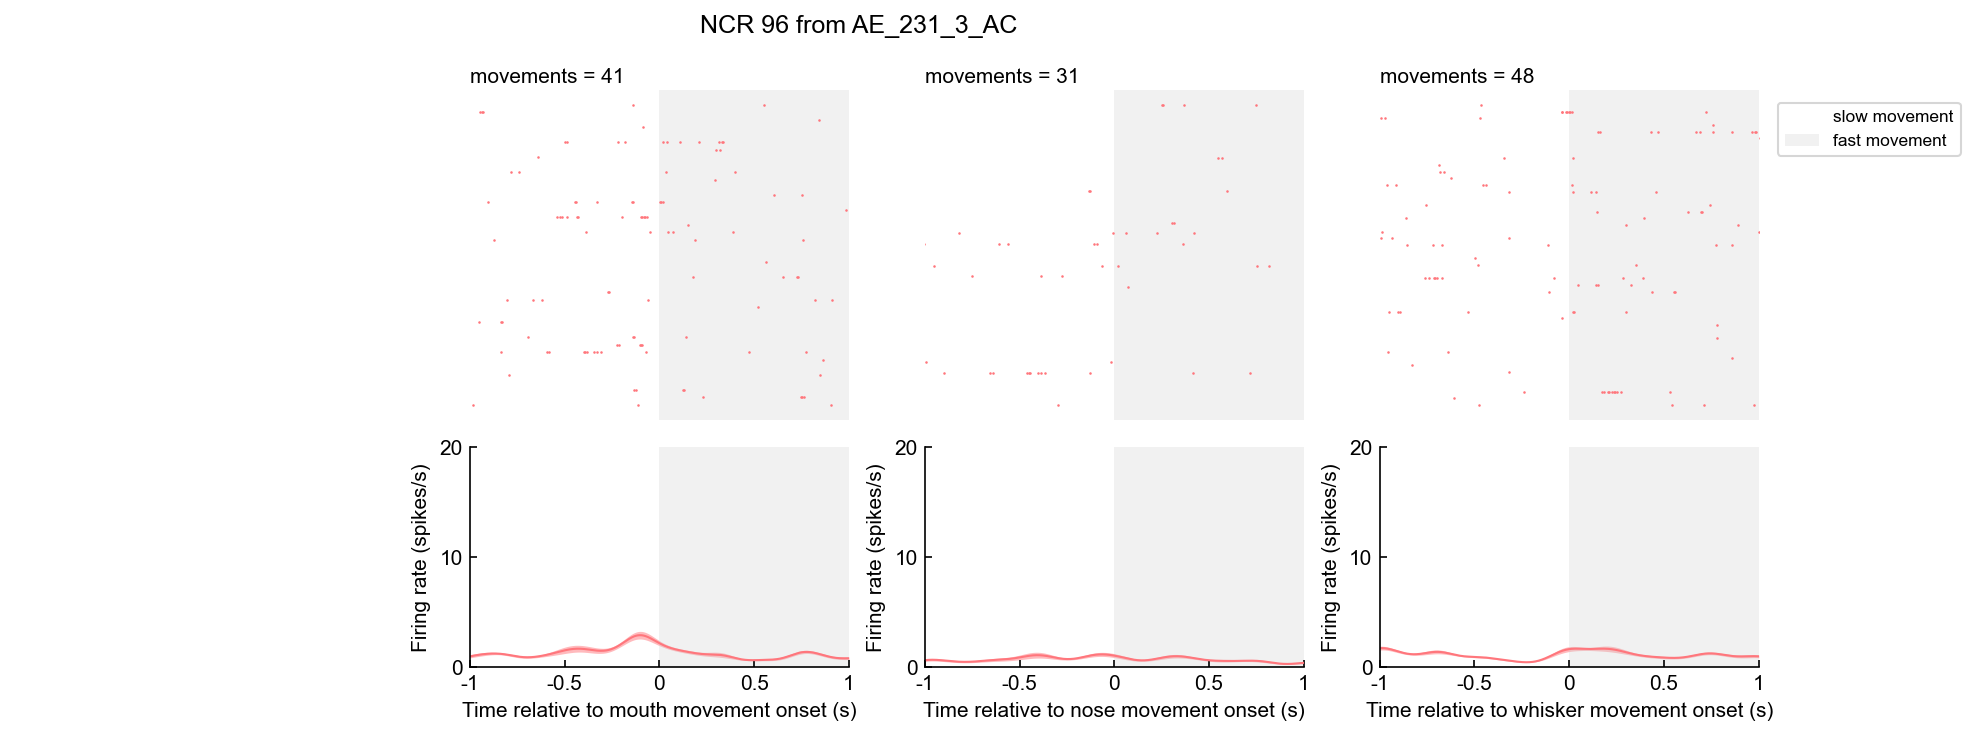

In [72]:
#Save all in PDF: Plots with same y-axis for across all NCR cells in PSTH
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt, patches

file_allmove = 'C:\\Users\\insan\\Desktop\\Motion final\\Raster and PSTH for individual NCR.pdf'
with PdfPages(file_allmove) as pdf:
    for clust in NCR_D9:
        fig = visualizeClusterMovement(sessionfile_D9,clust,limit_arr,'NCR') 
        pdf.savefig(fig)
        plt.close('all')

for clust in NCR_D9:
    fig = visualizeClusterMovement(sessionfile_D9,clust,limit_arr,'NCR') 
    fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion final\\png\\NCR',ilep.generateDateString(sessionfile_D9)+' '+str(clust)+'.png'),transparent=False,facecolor="white")


meta NOT subset; don't know how to subset; dropped


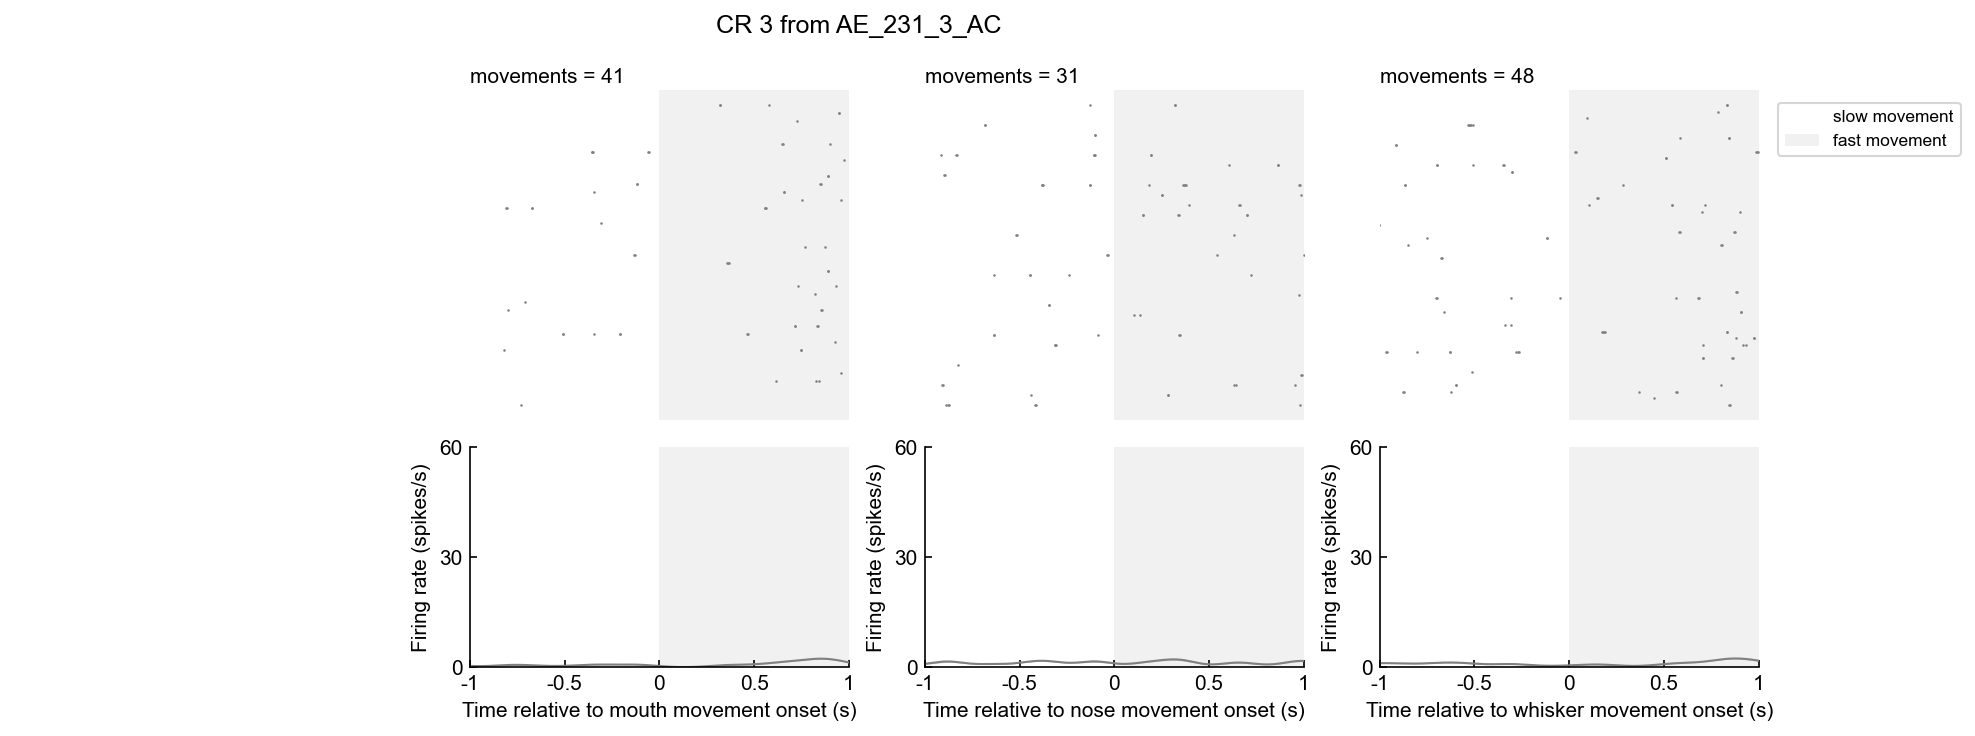

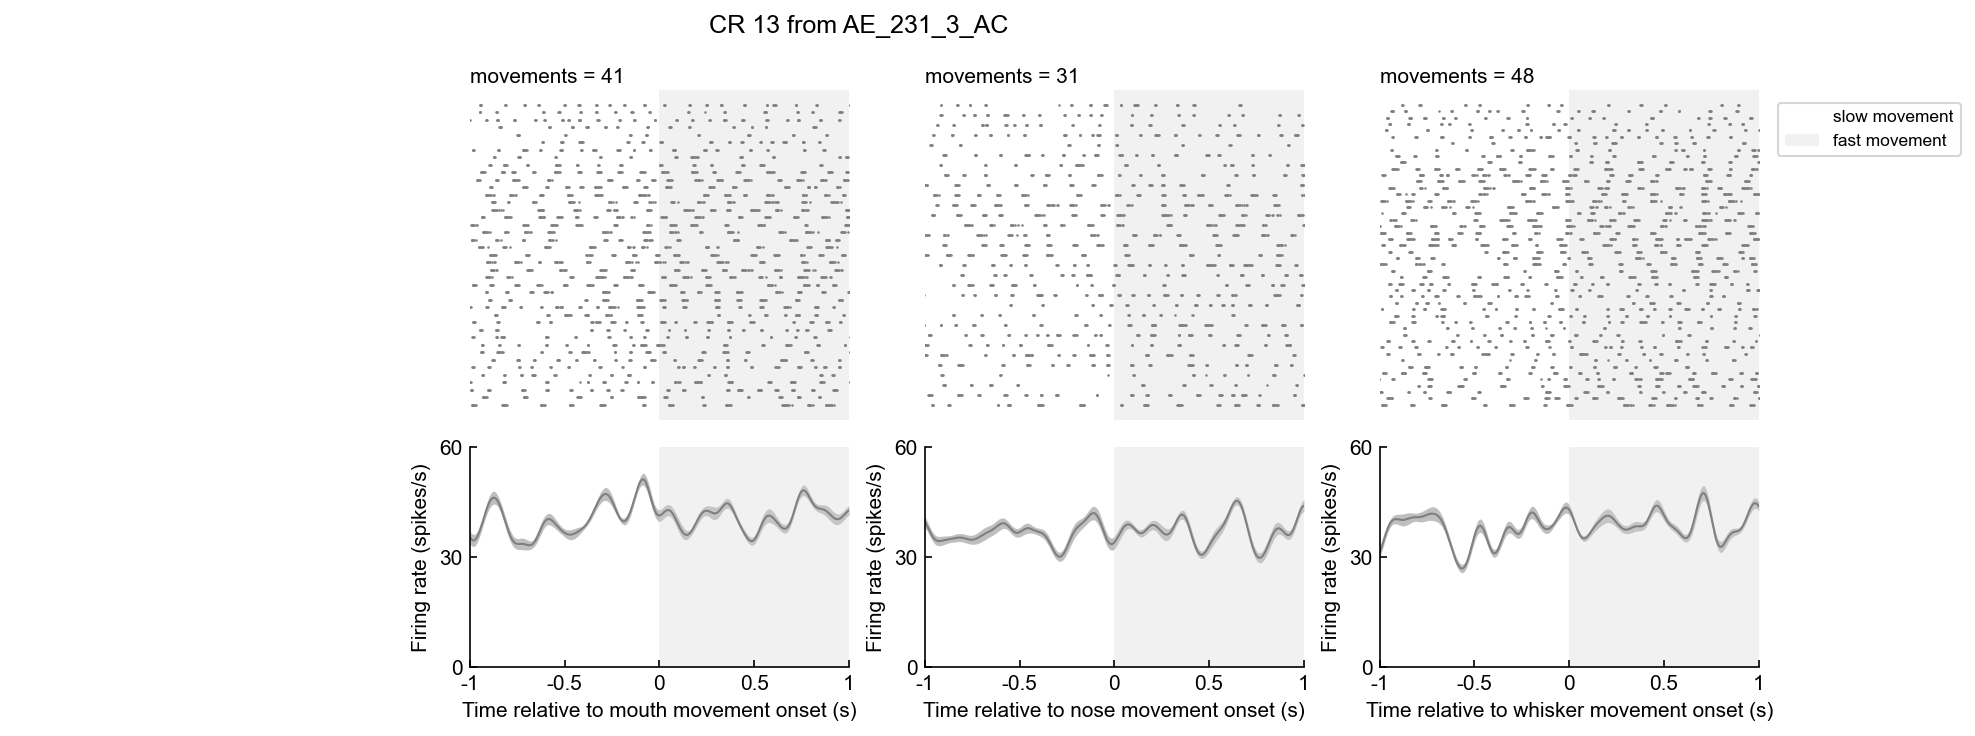

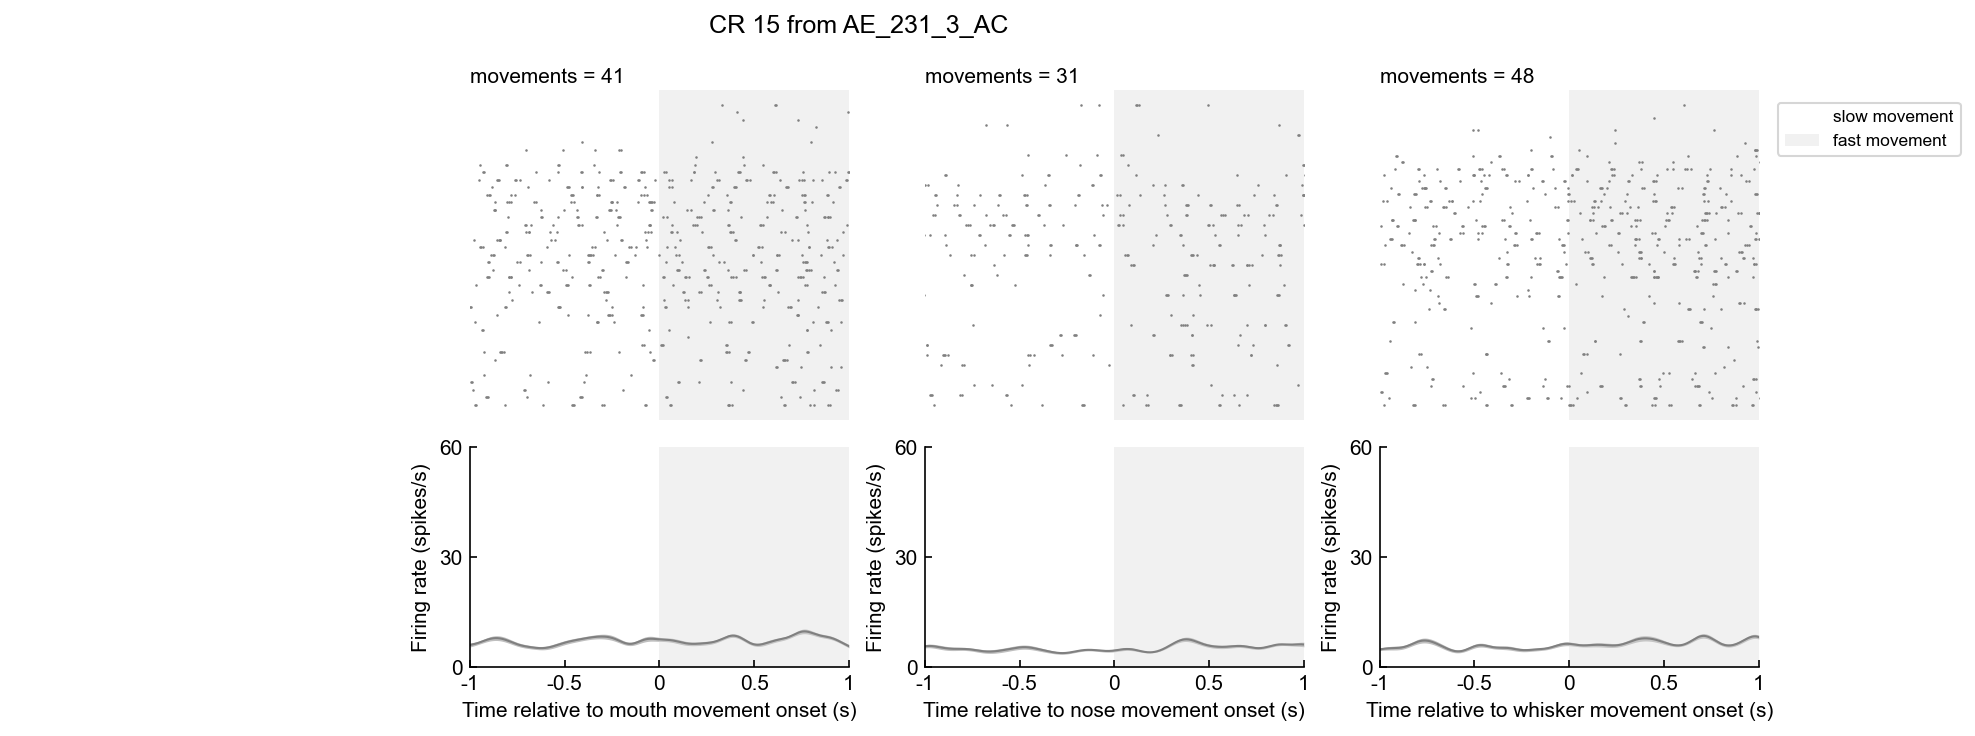

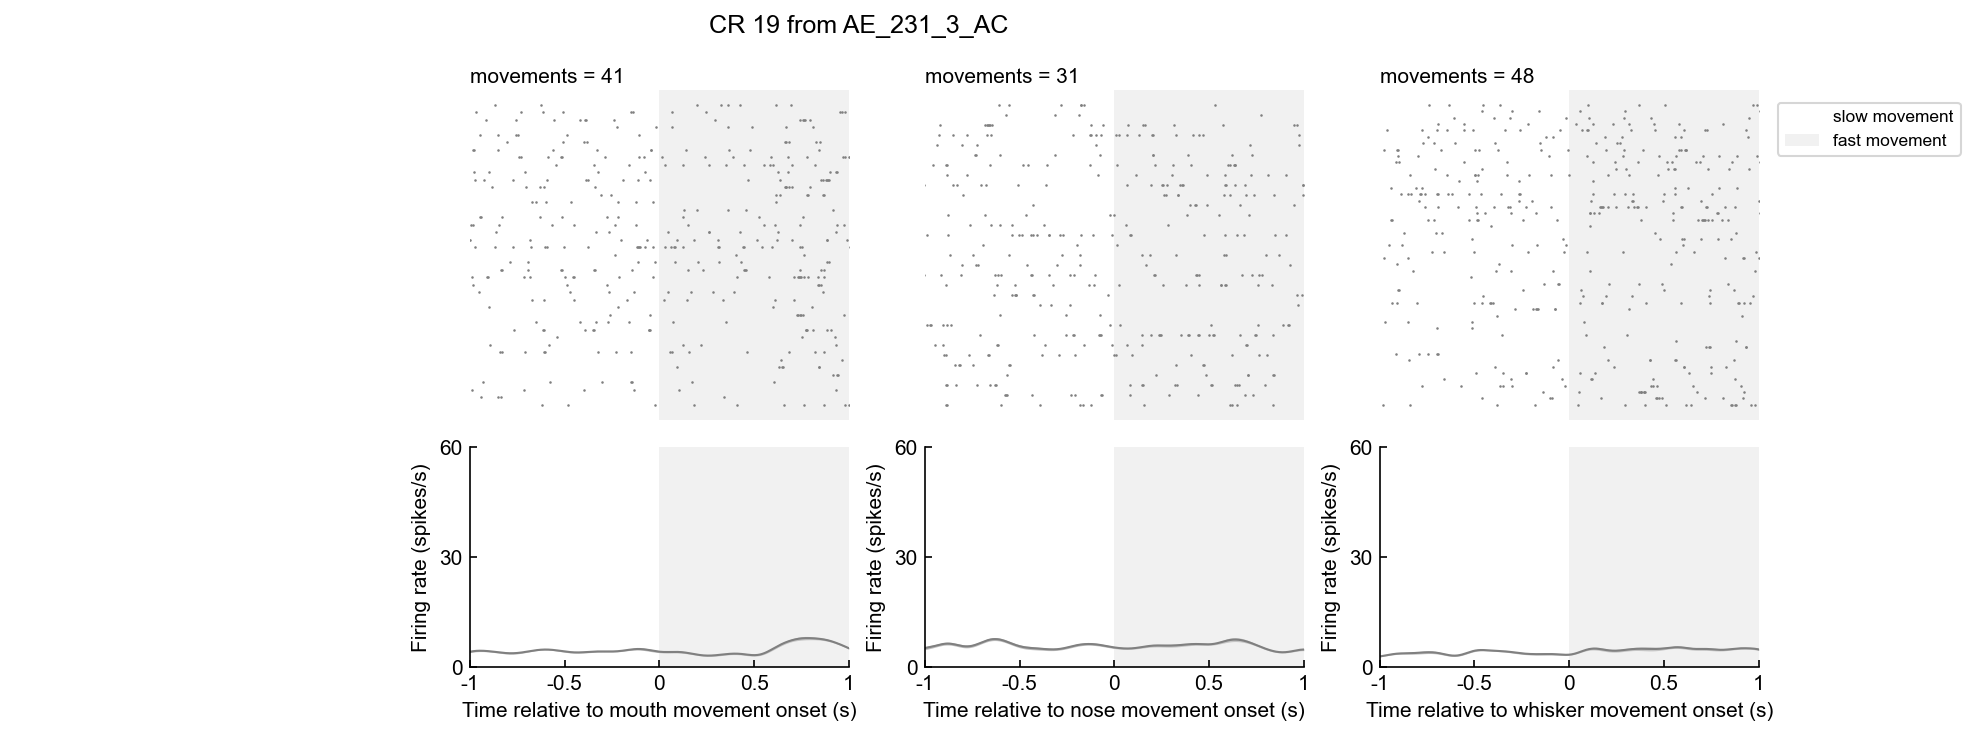

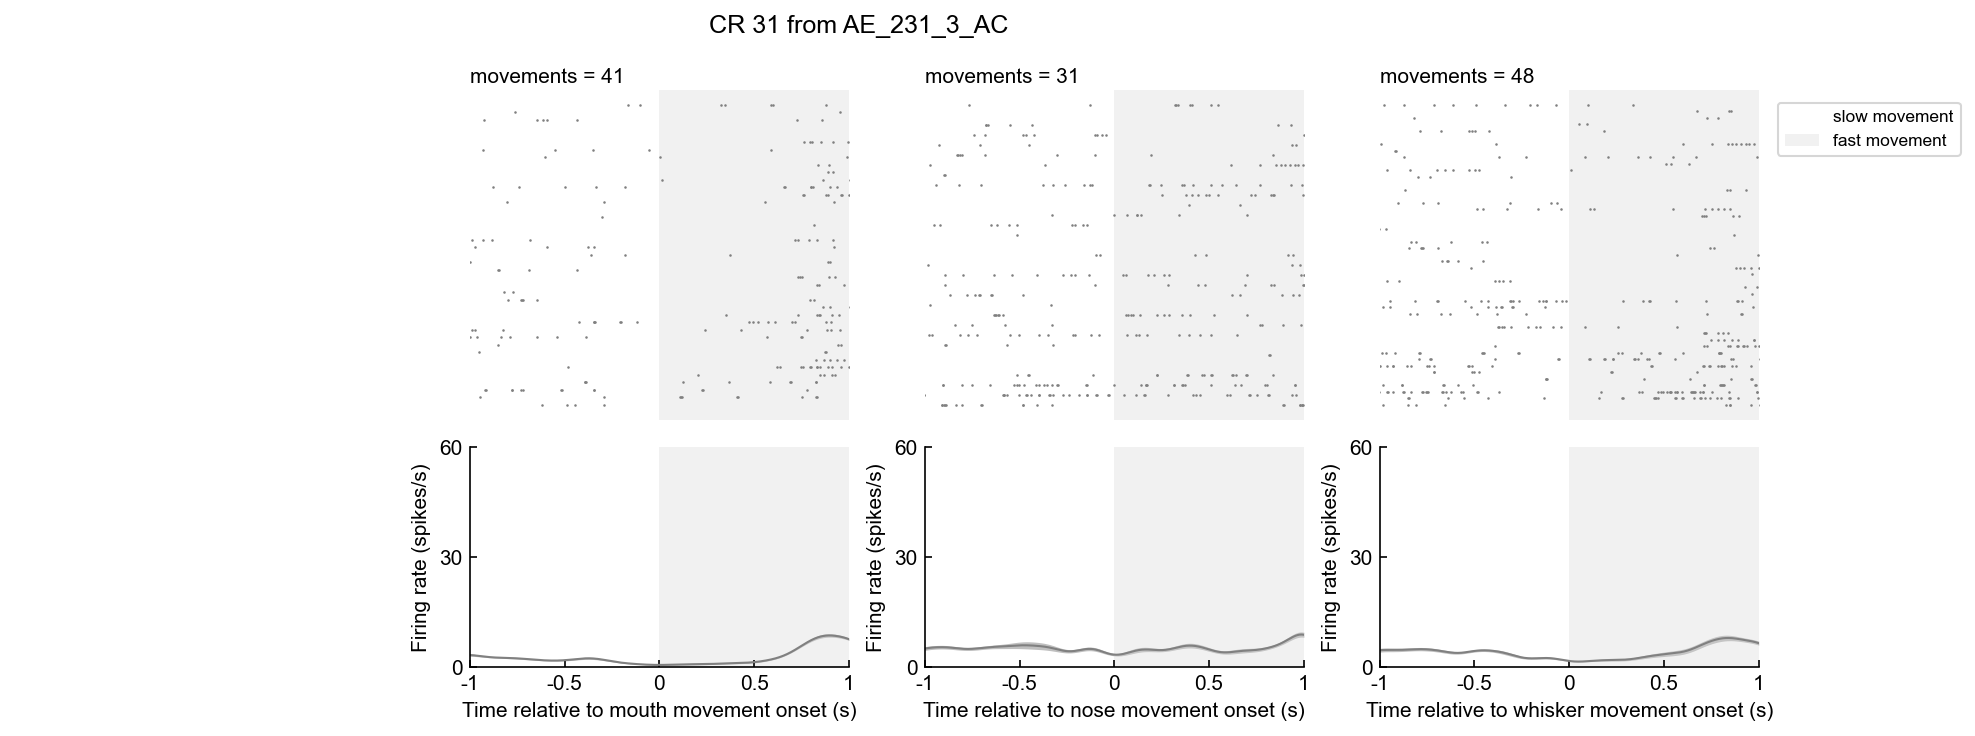

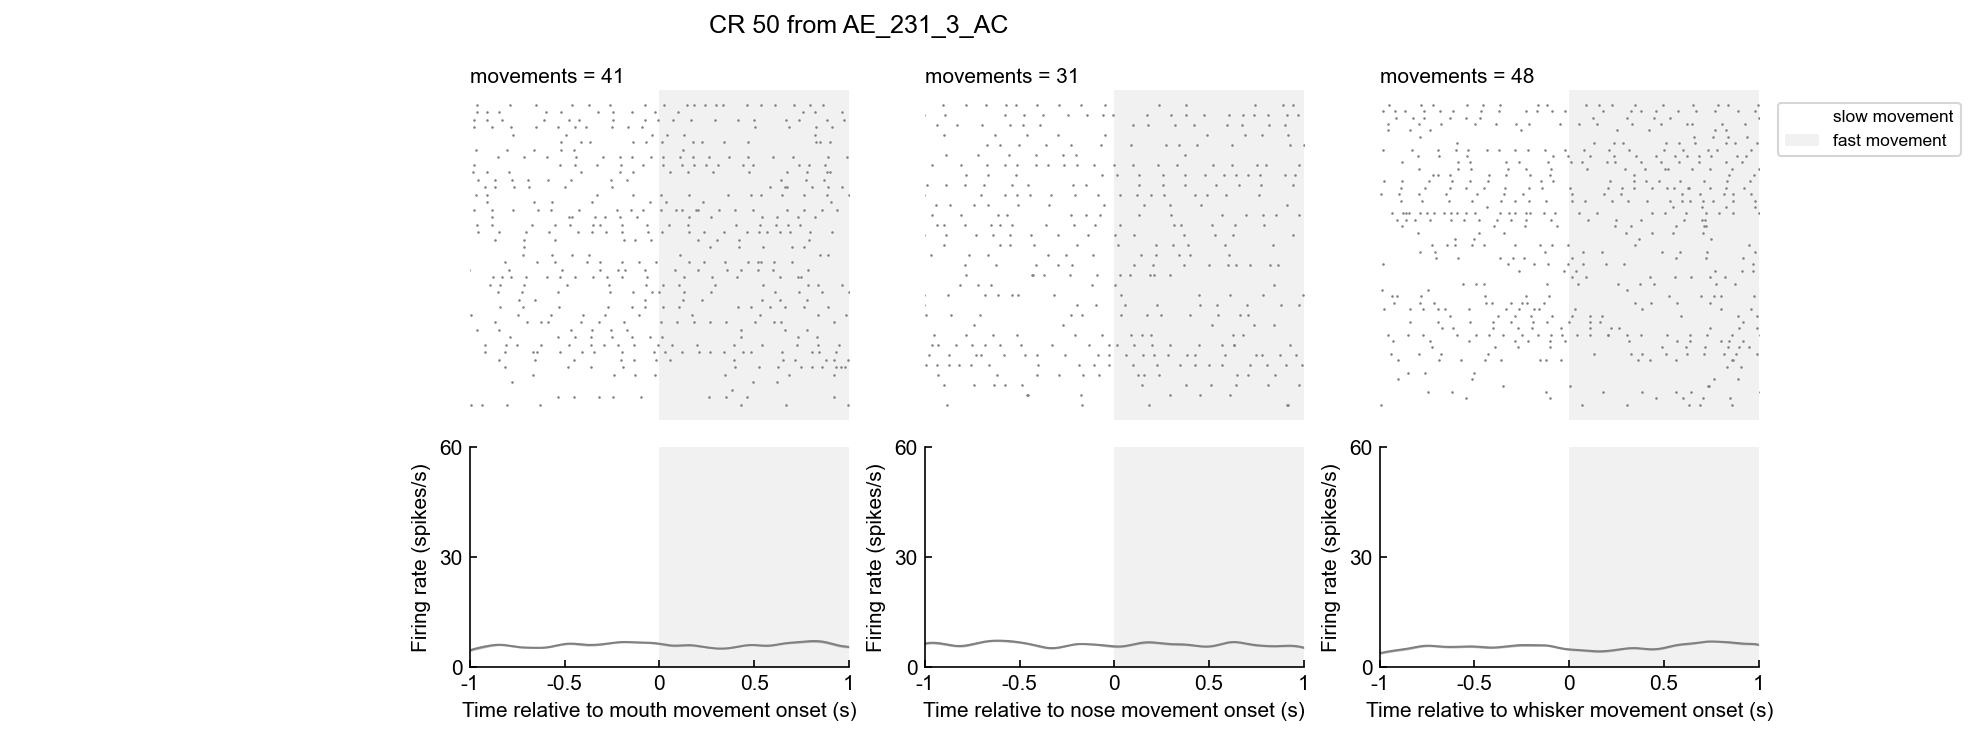

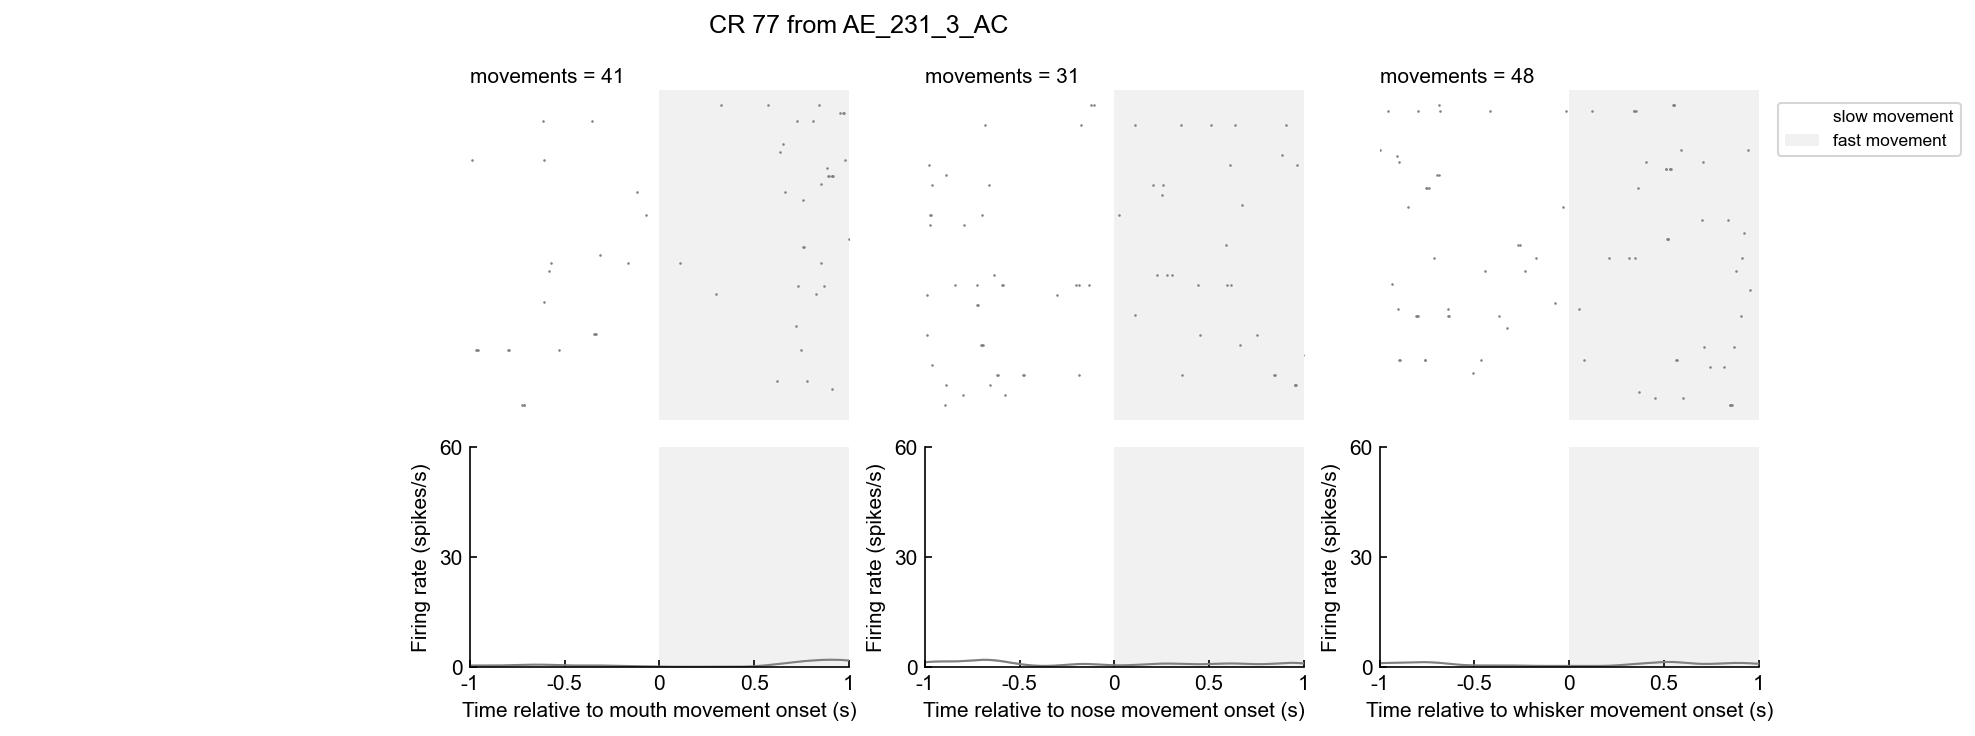

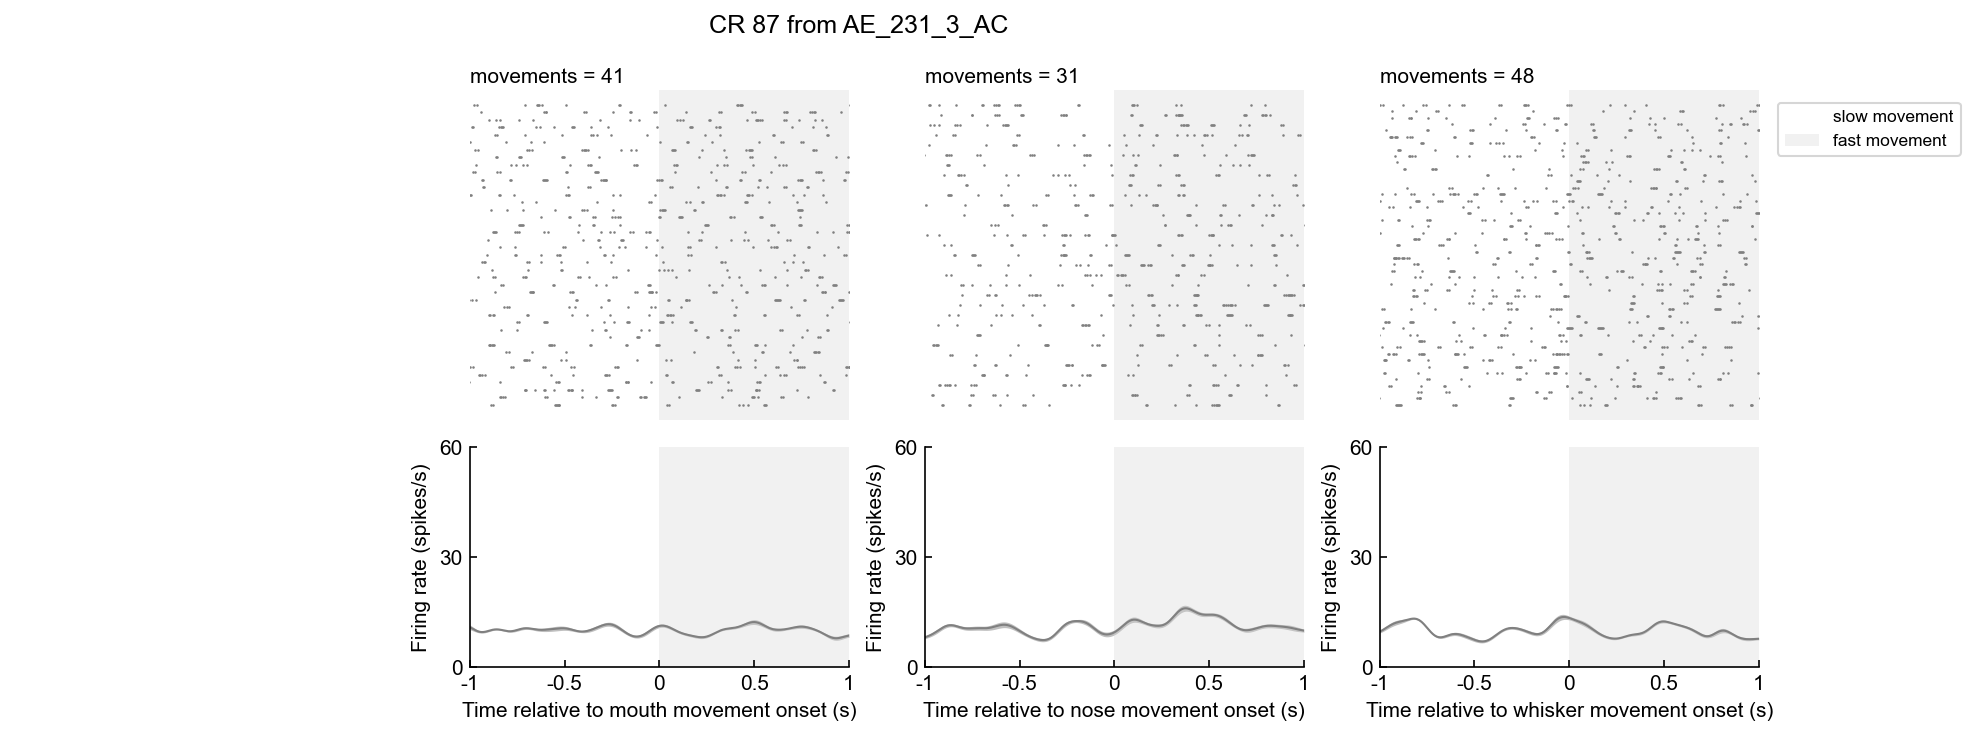

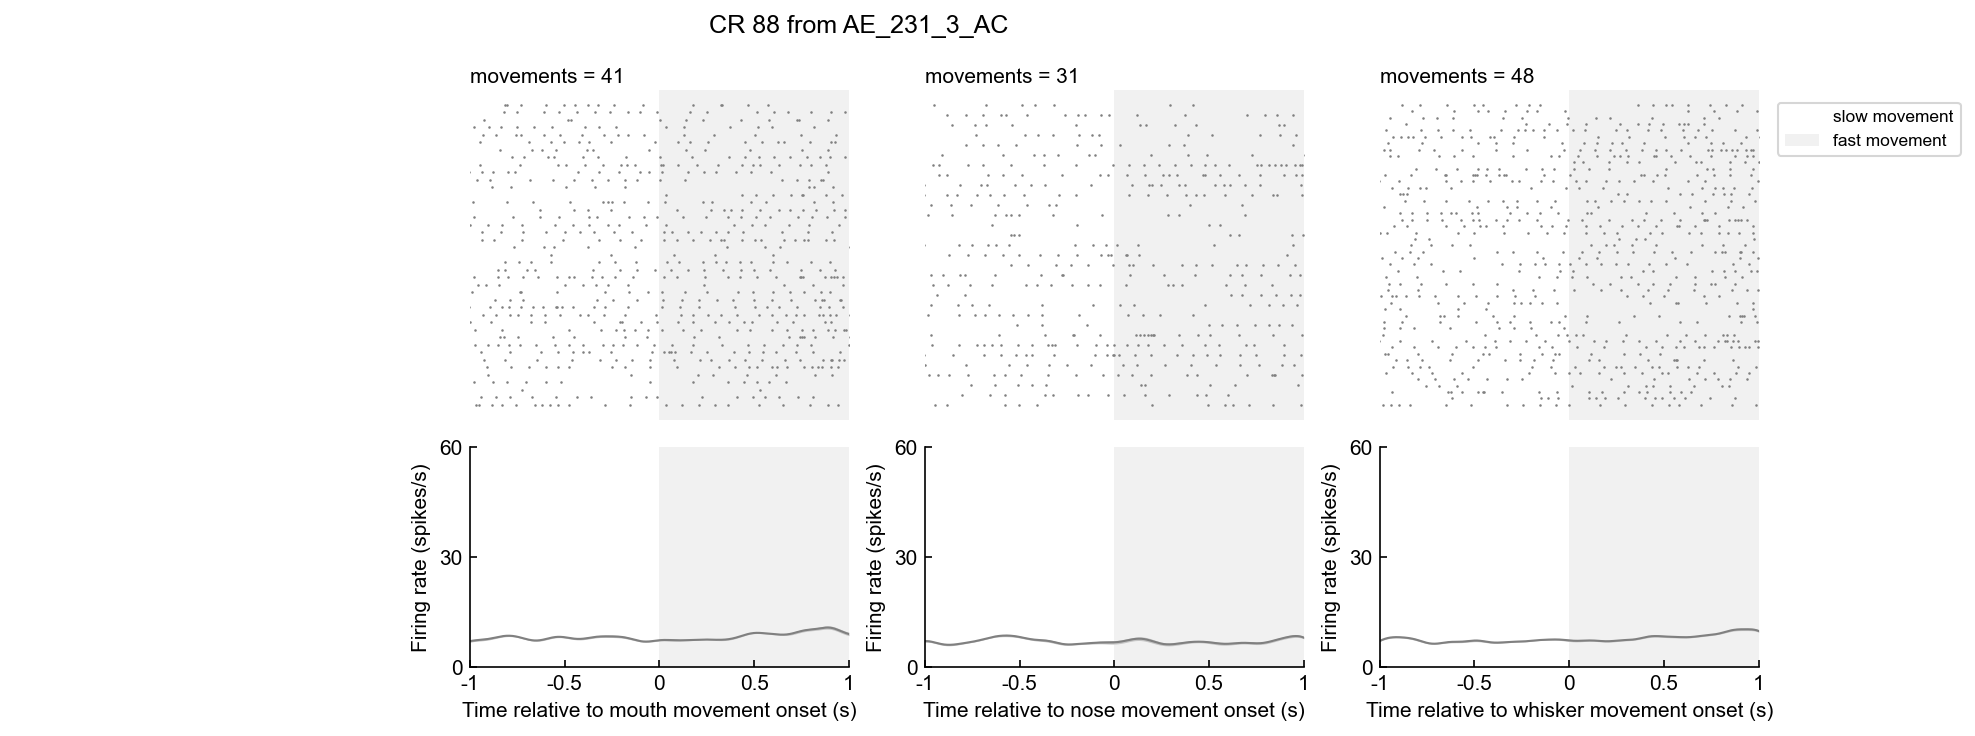

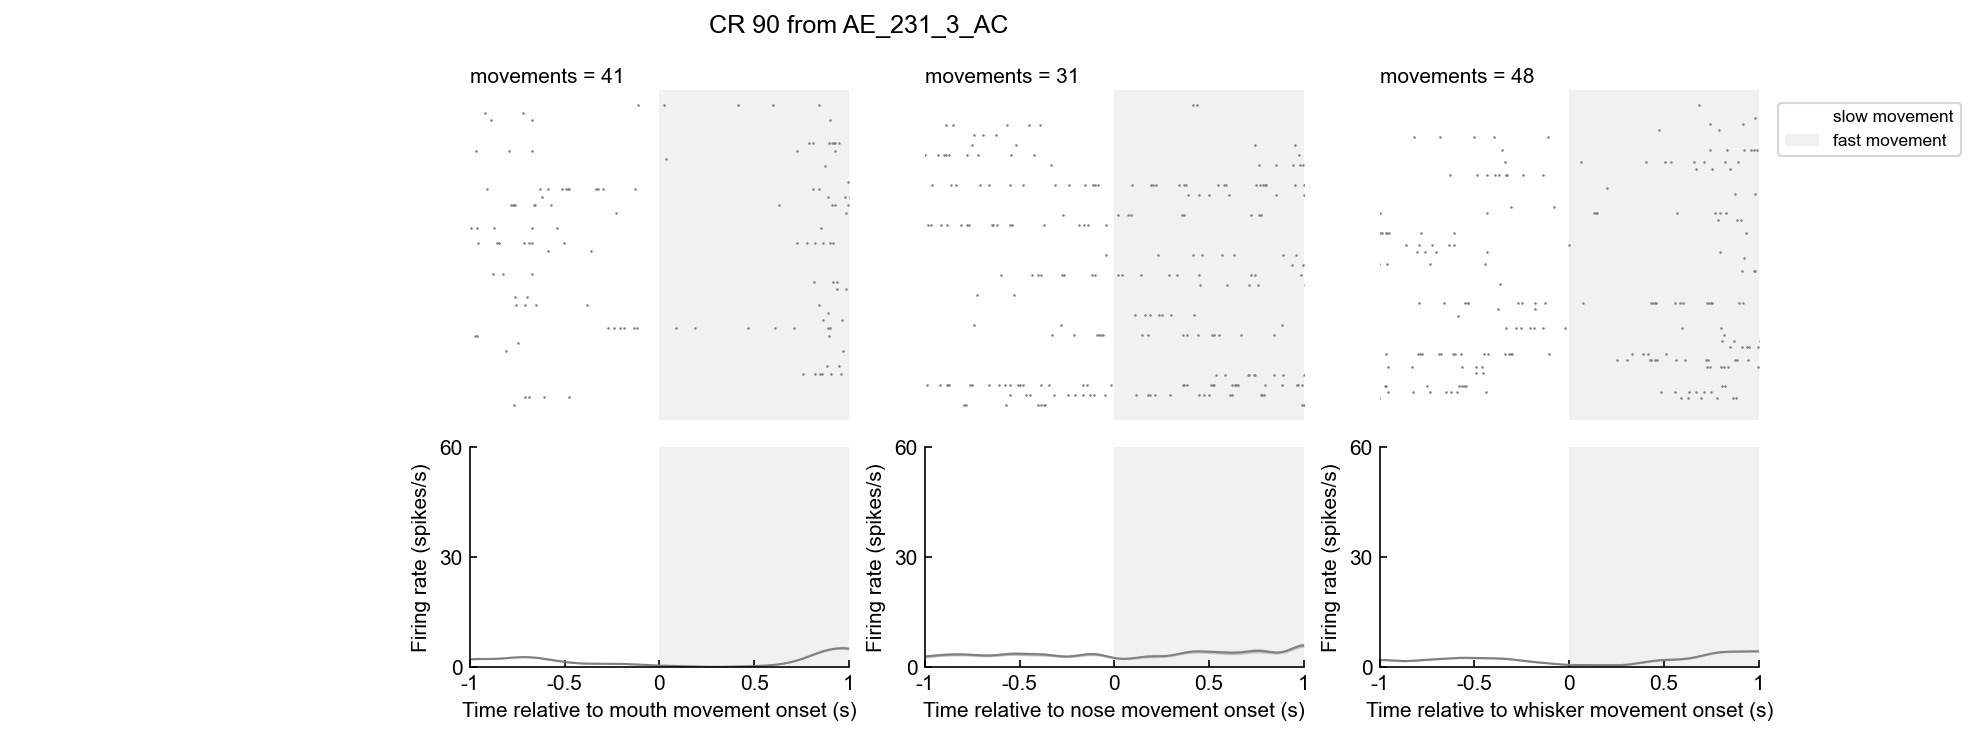

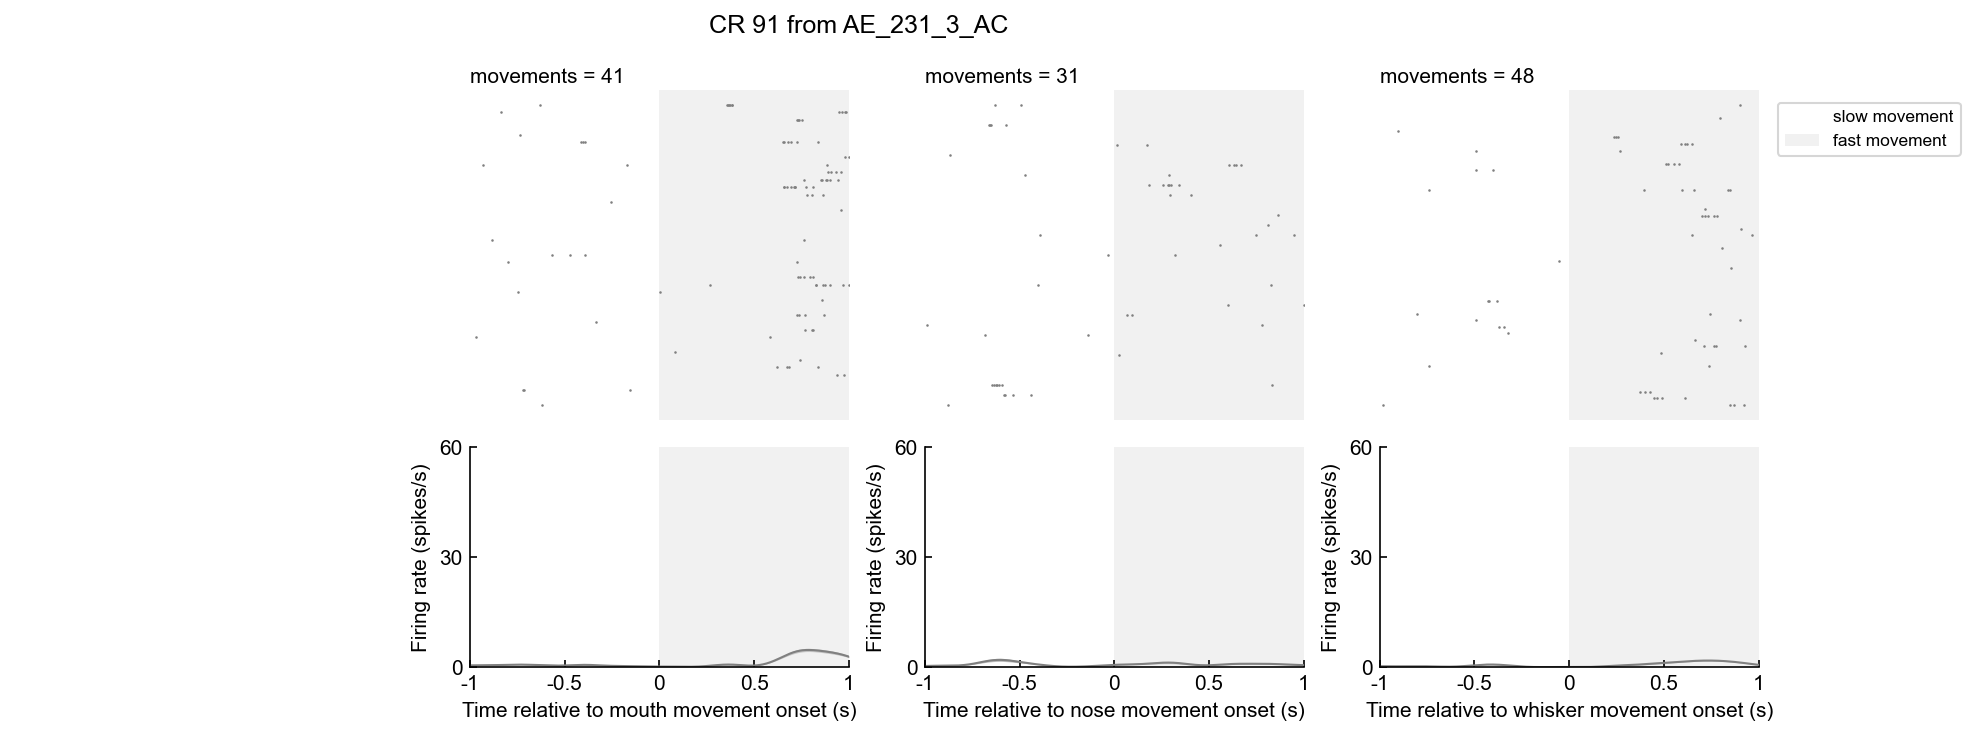

In [73]:
############same plot for CR
CR_integrate_limit_arr = []
CR_mouth_limit_arr = []
CR_nose_limit_arr = []
CR_whisker_limit_arr = []
for clust in CR_D9:
    CR_integrate_limit = CalculateforRasterPSTHLimit(sessionfile_D9,clust,integrate_3003_movement_onset_samples_arr)
    CR_integrate_limit_arr.append(CR_integrate_limit)
 
    CR_mouth_limit = CalculateforRasterPSTHLimit(sessionfile_D9,clust, mouth_3003_movement_onset_samples_arr)
    CR_mouth_limit_arr.append(CR_mouth_limit)
    
    CR_nose_limit = CalculateforRasterPSTHLimit(sessionfile_D9,clust, nose_3003_movement_onset_samples_arr)
    CR_nose_limit_arr.append(CR_nose_limit)
    
    CR_whisker_limit = CalculateforRasterPSTHLimit(sessionfile_D9,clust,whisker_3003_movement_onset_samples_arr)
    CR_whisker_limit_arr.append(CR_whisker_limit)

CR_integrate_limit_arr=np.array(CR_integrate_limit_arr)
CR_mouth_limit_arr = np.array(CR_mouth_limit_arr)
CR_nose_limit_arr = np.array(CR_nose_limit_arr)
CR_whisker_limit_arr = np.array(CR_whisker_limit_arr)
CR_limit_arr = np.concatenate((CR_integrate_limit_arr,CR_mouth_limit_arr,CR_nose_limit_arr,CR_whisker_limit_arr))

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt, patches

file_allmove = 'C:\\Users\\insan\\Desktop\\Motion final\\Raster and PSTH for individual CR.pdf'
with PdfPages(file_allmove) as pdf:
    for clust in CR_D9:
        fig = visualizeClusterMovement(sessionfile_D9,clust,CR_limit_arr,'CR')
        pdf.savefig(fig)
        plt.close('all')

for clust in CR_D9:
    fig = visualizeClusterMovement(sessionfile_D9,clust,CR_limit_arr,'CR')
    fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion final\\png\\CR',ilep.generateDateString(sessionfile_D9)+' '+str(clust)+'.png'),transparent=False,facecolor="white")
    

In [74]:
#############Plot PSTH across all NCR and CR cells DONT DELETE

In [75]:
############# NORMALIZE FR

In [76]:
 def CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots):
    
    def CalculateClustFR(clust):
        moveSpikes = []
        for movement in movementsToPlots:
            this_move_spike = ilep.getSpikeTimes(sessionfile_D9,clust=clust,starttime=movement-33000, endtime=movement+33000)
            moveSpikes.append(this_move_spike-movement)
        moveSpikes = np.array(moveSpikes,dtype='object') 
        
        bw_scott_factor = 3
        starttime = -30000 #samples
        endtime = starttime+60000 #samples
        xrange = np.linspace(starttime,endtime,num=1000)
        FR = np.full((10,len(xrange)),np.nan) 
        kf = KFold(n_splits=10)

        for idx,(move_index,_) in enumerate(kf.split(moveSpikes)):
            PSTHspikes = np.concatenate(moveSpikes[move_index])
            bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
            KDE = gaussian_kde(PSTHspikes,bw_method=bw)
            FR[idx,:] = KDE.evaluate(xrange)
            FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(move_index) *30000 #convert unit to seconds from samples
            
        avg_FR = np.mean(FR,axis=0) 
        base_FR = np.mean(avg_FR[:50]) 
        norm_FR = avg_FR/base_FR - 1
        return avg_FR, norm_FR 
    ###############  
    CR_norm_FR = []
    for clust in CR_D9:
        norm_FR = CalculateClustFR(clust)[1]
        CR_norm_FR.append(norm_FR)
    CR_norm_FR = np.array(CR_norm_FR)
    
    NCR_norm_FR = []
    for clust in NCR_D9:
        norm_FR = CalculateClustFR(clust)[1]
        NCR_norm_FR.append(norm_FR)
    NCR_norm_FR = np.array(NCR_norm_FR)
     
    CR_norm = np.mean(CR_norm_FR,axis=0)
    CR_sem = np.std(CR_norm_FR,axis=0)
    NCR_norm = np.mean(NCR_norm_FR,axis=0)
    NCR_sem = np.std(NCR_norm_FR,axis=0)
    return CR_norm, NCR_norm, CR_sem, NCR_sem

In [77]:
CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'

def visualizeClusterMovementAcrossCellsNormalize():
    movementsToPlots = [integrate_3003_movement_onset_samples_arr,mouth_3003_movement_onset_samples_arr,
                   nose_3003_movement_onset_samples_arr,whisker_3003_movement_onset_samples_arr]

    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    FRmod_color = NCR_CR_cmap( (FRmod-1)/5)
    #########################################################################################
    region = sessionfile.meta.region
    #########################################################################################

    fig = plt.figure(figsize=(15,5))
    #fig.suptitle('Normalized PSTH for all cells and speed plots')
    
    gs = fig.add_gridspec(2,4,height_ratios=[0.4,0.4],hspace=0.5)
    #Mouth
    ax2 = plt.subplot(gs[0,1])#PSTH
    #Nose
    ax3 = plt.subplot(gs[0,2],sharey=ax2)#PSTH
    #Whisker
    ax4 = plt.subplot(gs[0,3],sharey=ax2)#PSTH
    #Integrate
    ax1 = plt.subplot(gs[0,0],sharey=ax2)#PSTH 
    
    ax_PSTH = [ax2,ax3,ax4]
    
    ax5 = plt.subplot(gs[1,0],sharex=ax2)
    #Speed plot
    ax6 = plt.subplot(gs[1,1])
    ax7 = plt.subplot(gs[1,2],sharex=ax6)
    ax8 = plt.subplot(gs[1,3],sharex=ax6)
  

    ax5.spines['bottom'].set_visible(False)
    ax5.spines['left'].set_visible(False)
    ax5.get_xaxis().set_visible(False)
    ax5.get_yaxis().set_visible(False)
    ax5.scatter(np.random.rand(20),np.random.rand(20),color='r',alpha=0,s=1.5,marker='o',lw=0)
    
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    
    #PSTH
    starttime = -30000 #samples
    endtime = starttime+60000 #samples
    xrange = np.linspace(starttime,endtime,num=1000)
    #Not show(integrate movement)
    NCR_noravg_FR_Integrate = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[0])[1]
    NCR_norsem_FR_Integrate =  CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[0])[3]
    CR_noravg_FR_Integrate = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[0])[0]
    CR_norsem_FR_Integrate =  CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[0])[2]
    ax1.plot(xrange,NCR_noravg_FR_Integrate, lw=1,color=NCR_COLOR,label = 'NCR n=7',alpha=0)
    #ax1.fill_between(xrange,NCR_noravg_FR_Integrate-NCR_norsem_FR_Integrate,NCR_noravg_FR_Integrate+NCR_norsem_FR_Integrate,color=NCR_COLOR,alpha=0,zorder=-10,lw=0)
    ax1.set_xlabel('Time relative to all movement onset (s)')
    
    #Show
    NCR_noravg_FR_Mouth = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[1]
    NCR_norsem_FR_Mouth = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[3]
    CR_noravg_FR_Mouth = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[0]
    CR_norsem_FR_Mouth =  CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[2]
    ax2.plot(xrange,NCR_noravg_FR_Mouth, lw=1,color=NCR_COLOR,label = 'NCR')
    ax2.plot(xrange,CR_noravg_FR_Mouth,lw=1,color=CR_COLOR,label = 'CR')
    ax2.fill_between(xrange,NCR_noravg_FR_Mouth-NCR_norsem_FR_Mouth,NCR_noravg_FR_Mouth+NCR_norsem_FR_Mouth,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax2.fill_between(xrange,CR_noravg_FR_Mouth-CR_norsem_FR_Mouth,CR_noravg_FR_Mouth+CR_norsem_FR_Mouth,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax2.set_xlabel('Time relative to mouth movement onset (s)')
        
    NCR_noravg_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[1]
    NCR_norsem_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[3]
    CR_noravg_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[0]
    CR_norsem_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[2]
    ax3.plot(xrange,NCR_noravg_FR_Nose, lw=1,color=NCR_COLOR,label = 'NCR')
    ax3.plot(xrange,CR_noravg_FR_Nose,lw=1,color=CR_COLOR,label = 'CR')
    ax3.fill_between(xrange,NCR_noravg_FR_Nose-NCR_norsem_FR_Nose,NCR_noravg_FR_Nose+NCR_norsem_FR_Nose,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax3.fill_between(xrange,CR_noravg_FR_Nose-CR_norsem_FR_Nose,CR_noravg_FR_Nose+CR_norsem_FR_Nose,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax3.set_xlabel('Time relative to nose movement onset (s)')
    
    NCR_noravg_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[1]
    NCR_norsem_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[3]
    CR_noravg_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[0]
    CR_norsem_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[2]
    ax4.plot(xrange,NCR_noravg_FR_Whisker, lw=1,color=NCR_COLOR)
    ax4.plot(xrange,CR_noravg_FR_Whisker,lw=1,color=CR_COLOR)
    ax4.fill_between(xrange,NCR_noravg_FR_Whisker-NCR_norsem_FR_Whisker,NCR_noravg_FR_Whisker+NCR_norsem_FR_Whisker,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax4.fill_between(xrange,CR_noravg_FR_Whisker-CR_norsem_FR_Whisker,CR_noravg_FR_Whisker+CR_norsem_FR_Whisker,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax4.set_xlabel('Time relative to whisker movement onset (s)')
    
    ax1.set_ylim([-1,1.5])
    ax1.set_yticks([-1,0,1]) 
    #ax1.set_yticklabels(['0.2','0.6','1.0']) #plot purposes
 
    

    for ax in ax_PSTH:
        ax.axvspan(-30000,0, ymin=0,color='white', alpha=0.3, lw=0,label='slow movement') 
        ax.axvspan(0, 30000, ymin=0,color='lightgray', alpha=0.3, lw=0, label = 'fast movement')
        ax.set_ylabel('Normalized change in firing rate')
        ax.set_xlim([-30000,30000])
        ax.set_xticks([-30000,-15000,0,15000, 30000])
        #ax.set_xticklabels(['-100','-0.5','0','0.5','1']) #for plot purposes
        ax.set_xticklabels(['-1','-0.5','0','0.5','1']) #real
        #ax.text(18000,1.5,'NCR n=7',color=NCR_COLOR)
        #ax.text(18000,1.5+0.25,'CR n=11',color=CR_COLOR)

    ax4.legend(frameon=True,loc=(1.05,0.7))
    #Speed plot
    #Mouth speed plot
    ax6.plot(avg_mouth_3003_speed,color='#969696')
    ax6.set_xlim([0,400])
    #ax6.set_xticklabels(['-100','-50','0','50','100'])
    ax6.set_ylabel('Averaged speed (mouth)')
    ax6.set_xlabel('Time relative to mouth movement onset \n(frames)')
    #ax6.axvline(200,color='black',linestyle='--',zorder=10,lw=1)
    ax6.set_ylim([0.2,1])
    ax6.set_yticks([0.2,0.6,1.0])
    ax6.axvspan(200, 300, ymin=0,color='lightgray', alpha=0.3, lw=0)
    
    #Nose speed plot
    ax7.plot(avg_nose_3003_speed,color='#969696')
    ax7.set_xlim([100,300])
    ax7.set_xticklabels(['-100','-50','0','50','100'])
    ax7.set_ylabel('Averaged speed (nose)')
    ax7.set_xlabel('Time relative to nose movement onset \n(frames)')
    #ax7.axvline(200,color='black',linestyle='--',zorder=10,lw=1)
    ax7.set_ylim([0.2,1])
    ax7.set_yticks([0.2,0.6,1.0])
    ax7.axvspan(200, 300, ymin=0,color='lightgray', alpha=0.3, lw=0)
    
    #Whisker speed plot
    ax8.plot(avg_whisker_3003_speed,color='#969696')
    ax8.set_xlim([100,300])
    ax8.set_xticklabels(['-100','-50','0','50','100'])
    ax8.set_ylabel('Averaged speed (whisker)')
    ax8.set_xlabel('Time relative to whisker movement onset \n(frames)')
    #ax8.axvline(200,color='black',linestyle='--',zorder=10,lw=1)
    ax8.set_ylim([0.2,1])
    ax8.set_yticks([0.2,0.6,1.0])
    ax8.axvspan(200, 300, ymin=0,color='lightgray', alpha=0.3, lw=0)
    
    plt.close()
    return fig
    

C:\Users\insan\AppData\Local\Temp\ipykernel_14808\1028636318.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax7.set_xticklabels(['-100','-50','0','50','100'])
C:\Users\insan\AppData\Local\Temp\ipykernel_14808\1028636318.py:135: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax8.set_xticklabels(['-100','-50','0','50','100'])


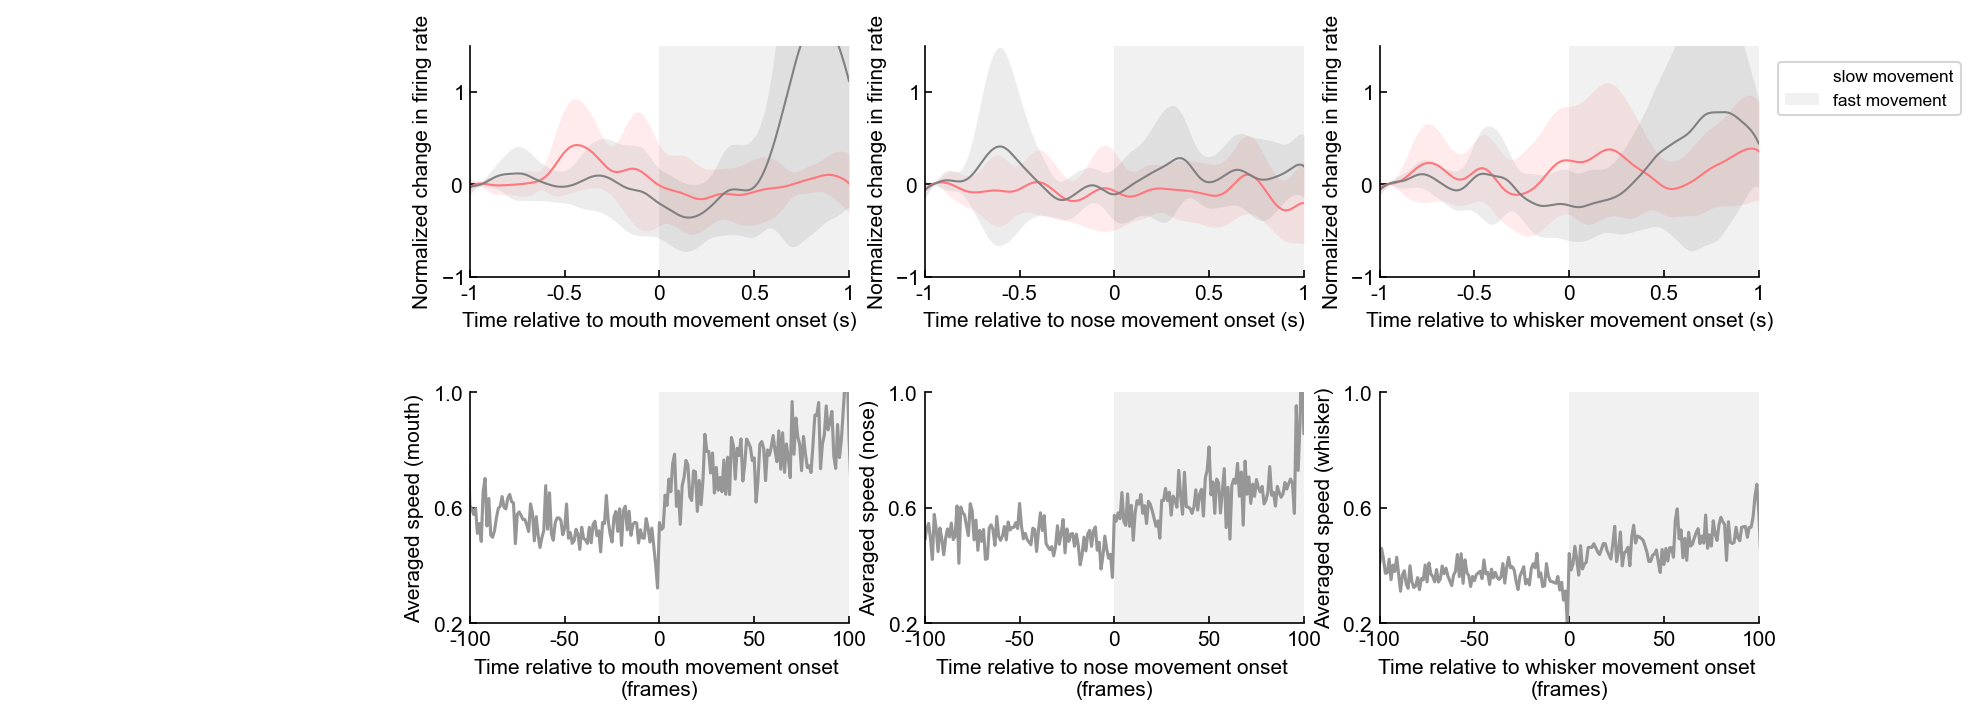

In [78]:
fig = visualizeClusterMovementAcrossCellsNormalize()
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion final\\png\\Normalized PSTH across all CRs and NCRs.png'),transparent=False,facecolor="white")
fig


In [79]:
#Save all in PDF: Plots with same y-axis for each cell in PSTH
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt, patches

file_PSTH = 'C:\\Users\insan\\Desktop\\Motion final\\Normalized PSTH across all CRs and NCRs.pdf'
with PdfPages(file_PSTH) as pdf:
    pdf.savefig(fig)
    plt.close('all')

###################

meta NOT subset; don't know how to subset; dropped


In [80]:
CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'

def visualizeClusterMovementAcrossCellsNormalizewithtonereward():
    movementsToPlots = [integrate_3003_movement_onset_samples_arr,mouth_3003_movement_onset_samples_arr,
                   nose_3003_movement_onset_samples_arr,whisker_3003_movement_onset_samples_arr]

    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    FRmod_color = NCR_CR_cmap( (FRmod-1)/5)
    #########################################################################################
    region = sessionfile.meta.region
    #########################################################################################

    fig = plt.figure(figsize=(15,5))
    #fig.suptitle('PSTH for all cells from AE_231_3_AC')
    
    gs = fig.add_gridspec(2,4,height_ratios=[0.4,0.4],hspace=0.5)
    #Integrate
    ax1 = plt.subplot(gs[0,0])#PSTH 
    #Mouth
    ax2 = plt.subplot(gs[0,1],sharey=ax1)#PSTH
    #Nose
    ax3 = plt.subplot(gs[0,2],sharey=ax1)#PSTH
    #Whisker
    ax4 = plt.subplot(gs[0,3],sharey=ax1)#PSTH
    
    ax_PSTH = [ax1,ax2,ax3,ax4]
    
    ax5 = plt.subplot(gs[1,0],sharex=ax1)
    #Speed plot
    ax6 = plt.subplot(gs[1,1])
    ax7 = plt.subplot(gs[1,2],sharex=ax6)
    ax8 = plt.subplot(gs[1,3],sharex=ax6)
  

    ax5.spines['bottom'].set_visible(False)
    ax5.spines['left'].set_visible(False)
    ax5.get_xaxis().set_visible(False)
    ax5.get_yaxis().set_visible(False)
    ax5.scatter(np.random.rand(20),np.random.rand(20),color='r',alpha=0,s=1.5,marker='o',lw=0)
    
    #PSTH
    starttime = -30000 #samples
    endtime = starttime+60000 #samples
    xrange = np.linspace(starttime,endtime,num=1000)
    
    NCR_noravg_FR_Integrate = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[0])[1]
    NCR_norsem_FR_Integrate =  CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[0])[3]
    CR_noravg_FR_Integrate = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[0])[0]
    CR_norsem_FR_Integrate =  CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[0])[2]
    ax1.plot(xrange,NCR_noravg_FR_Integrate, lw=1,color=NCR_COLOR,label = 'NCR')
    ax1.plot(xrange,CR_noravg_FR_Integrate,lw=1,color=CR_COLOR,label = 'CR')
    ax1.fill_between(xrange,NCR_noravg_FR_Integrate-NCR_norsem_FR_Integrate,NCR_noravg_FR_Integrate+NCR_norsem_FR_Integrate,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax1.fill_between(xrange,CR_noravg_FR_Integrate-CR_norsem_FR_Integrate,CR_noravg_FR_Integrate+CR_norsem_FR_Integrate,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax1.annotate('movements = 120', xy=(0, 1.04), xycoords='axes fraction', xytext=(0, 1.02),color='black')
    ax1.set_xlabel('Time relative to all movement onset (s)')
        
    NCR_noravg_FR_Mouth = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[1]
    NCR_norsem_FR_Mouth = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[3]
    CR_noravg_FR_Mouth = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[0]
    CR_norsem_FR_Mouth =  CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[1])[2]
    ax2.plot(xrange,NCR_noravg_FR_Mouth, lw=1,color=NCR_COLOR,label = 'NCR')
    ax2.plot(xrange,CR_noravg_FR_Mouth,lw=1,color=CR_COLOR,label = 'CR')
    ax2.fill_between(xrange,NCR_noravg_FR_Mouth-NCR_norsem_FR_Mouth,NCR_noravg_FR_Mouth+NCR_norsem_FR_Mouth,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax2.fill_between(xrange,CR_noravg_FR_Mouth-CR_norsem_FR_Mouth,CR_noravg_FR_Mouth+CR_norsem_FR_Mouth,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax2.annotate('movements = 41', xy=(0, 1.04), xycoords='axes fraction', xytext=(0, 1.02),color='black')
    ax2.set_xlabel('Time relative to mouth movement onset (s)')
        
    NCR_noravg_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[1]
    NCR_norsem_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[3]
    CR_noravg_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[0]
    CR_norsem_FR_Nose = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[2])[2]
    ax3.plot(xrange,NCR_noravg_FR_Nose, lw=1,color=NCR_COLOR,label = 'NCR')
    ax3.plot(xrange,CR_noravg_FR_Nose,lw=1,color=CR_COLOR,label = 'CR')
    ax3.fill_between(xrange,NCR_noravg_FR_Nose-NCR_norsem_FR_Nose,NCR_noravg_FR_Nose+NCR_norsem_FR_Nose,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax3.fill_between(xrange,CR_noravg_FR_Nose-CR_norsem_FR_Nose,CR_noravg_FR_Nose+CR_norsem_FR_Nose,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax3.annotate('movements = 31', xy=(0, 1.04), xycoords='axes fraction', xytext=(0, 1.02),color='black')
    ax3.set_xlabel('Time relative to nose movement onset (s)')
    
    NCR_noravg_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[1]
    NCR_norsem_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[3]
    CR_noravg_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[0]
    CR_norsem_FR_Whisker = CalculateforRasterPSTHAcrossCellsNormalize(movementsToPlots[3])[2]
    ax4.plot(xrange,NCR_noravg_FR_Whisker, lw=1,color=NCR_COLOR,label = 'NCR n=7')
    ax4.plot(xrange,CR_noravg_FR_Whisker,lw=1,color=CR_COLOR,label = 'CR n=11')
    ax4.fill_between(xrange,NCR_noravg_FR_Whisker-NCR_norsem_FR_Whisker,NCR_noravg_FR_Whisker+NCR_norsem_FR_Whisker,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax4.fill_between(xrange,CR_noravg_FR_Whisker-CR_norsem_FR_Whisker,CR_noravg_FR_Whisker+CR_norsem_FR_Whisker,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax4.annotate('movements = 48', xy=(0, 1.04), xycoords='axes fraction', xytext=(0, 1.02),color='black')
    ax4.set_xlabel('Time relative to whisker movement onset (s)')
    
    #Investigate CR modulation
   
    for tone_time in mouth_tone:
        tone_range=[tone_time,tone_time+0.1*30000]
        ax2.fill_between(tone_range,1.5, 1.3, color = 'darkcyan',alpha=0.3)
        #ax2.axvline(tone_time,0.97,1,color='r')
    for tone_time in nose_tone:
        tone_range=[tone_time,tone_time+0.1*30000]
        ax3.fill_between(tone_range,1.5, 1.3, color = 'darkcyan',alpha=0.3)
        #ax3.axvline(tone_time,0.97,1,color='r')
    for tone_time in whisker_tone:
        tone_range=[tone_time,tone_time+0.1*30000]
        ax4.fill_between(tone_range,1.5, 1.3, color = 'darkcyan',alpha=0.3)
        #ax4.axvline(tone_time,0.97,1,color='r')
        
    for reward_time in mouth_reward:
        reward_range=[reward_time,reward_time+100]
        ax2.fill_between(reward_range,1.29, 1.09, color = 'darkviolet',alpha=0.3)
        #ax2.axvline(reward_time,0.8,1.1,color='b',alpha=0.2)
    for reward_time in nose_reward:
        reward_range=[reward_time,reward_time+100]
        ax3.fill_between(reward_range,1.29, 1.09, color = 'darkviolet',alpha=0.3)
        #ax3.axvline(reward_time,0.8,1.1,color='b',alpha=0.2)
    for reward_time in whisker_reward:
        reward_range=[reward_time,reward_time+100]
        ax4.fill_between(reward_range,1.29, 1.09, color = 'darkviolet',alpha=0.3)
        #ax4.axvline(reward_time,0.8,1.1,color='b',alpha=0.2)
        
    ax4.axvline(-33000,color='darkcyan',label='tone duration (0.1s)')
    ax4.axvline(-33000,color='darkviolet',label='reward time')
    
    ax1.set_ylim([-1,1.5])
    ax1.set_yticks([-1,0,1])

    for ax in ax_PSTH:
        ax.axvspan(-30000,0, ymin=0,color='white', alpha=0.3, lw=0,label='slow movement') 
        ax.axvspan(0, 30000, ymin=0,color='lightgray', alpha=0.3, lw=0, label = 'fast movement')
        ax.set_ylabel('Normalized change in firing rate')
        ax.set_xlim([-30000,30000])
        ax.set_xticks([-30000,-15000,0,15000, 30000])
        ax.set_xticklabels(['-1','-0.5','0','0.5','1'])
        #ax.text(18000,1.5,'NCR n=7',color=NCR_COLOR)
        #ax.text(18000,1.8,'CR n=11',color=CR_COLOR)

    ax4.legend(frameon=True,loc=(1.05,0.7))
    
    #Speed plot
    #Mouth speed plot
    ax6.plot(avg_mouth_3003_speed)
    ax6.set_xlim([0,400])
    #ax6.set_xticklabels(['-100','-50','0','50','100'])
    ax6.set_ylabel('Averaged speed(mouth)')
    ax6.set_xlabel('Time relative to mouth movement onset \n(frames)')
    ax6.axvline(200,color='black',linestyle='--',zorder=10,lw=1)
    # ax6.set_yticks([0,0.4,0.8])
    ax6.set_ylim([0.2,1])
    ax6.axvspan(200, 300, ymin=0,color='lightgray', alpha=0.3, lw=0)
    
    #Nose speed plot
    ax7.plot(avg_nose_3003_speed)
    ax7.set_xlim([100,300])
    ax7.set_xticklabels(['-100','-50','0','50','100'])
    ax7.set_ylabel('Averaged speed(nose)')
    ax7.set_xlabel('Time relative to nose movement onset \n(frames)')
    ax7.axvline(200,color='black',linestyle='--',zorder=10,lw=1)
    # ax7.set_yticks([0,0.4,0.8])
    ax7.set_ylim([0.2,1])
    ax7.axvspan(200, 300, ymin=0,color='lightgray', alpha=0.3, lw=0)
    
    #Whisker speed plot
    ax8.plot(avg_whisker_3003_speed)
    ax8.set_xlim([100,300])
    ax8.set_xticklabels(['-100','-50','0','50','100'])
    ax8.set_ylabel('Averaged speed(whisker)')
    ax8.set_xlabel('Time relative to whisker movement onset \n(frames)')
    ax8.axvline(200,color='black',linestyle='--',zorder=10,lw=1)
    # ax8.set_yticks([0,0.4,0.8])
    ax8.set_ylim([0.2,1])
    ax8.axvspan(200, 300, ymin=0,color='lightgray', alpha=0.3, lw=0)
    
    plt.close()
    return fig
    

C:\Users\insan\AppData\Local\Temp\ipykernel_14808\3576912835.py:152: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax7.set_xticklabels(['-100','-50','0','50','100'])
C:\Users\insan\AppData\Local\Temp\ipykernel_14808\3576912835.py:163: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax8.set_xticklabels(['-100','-50','0','50','100'])


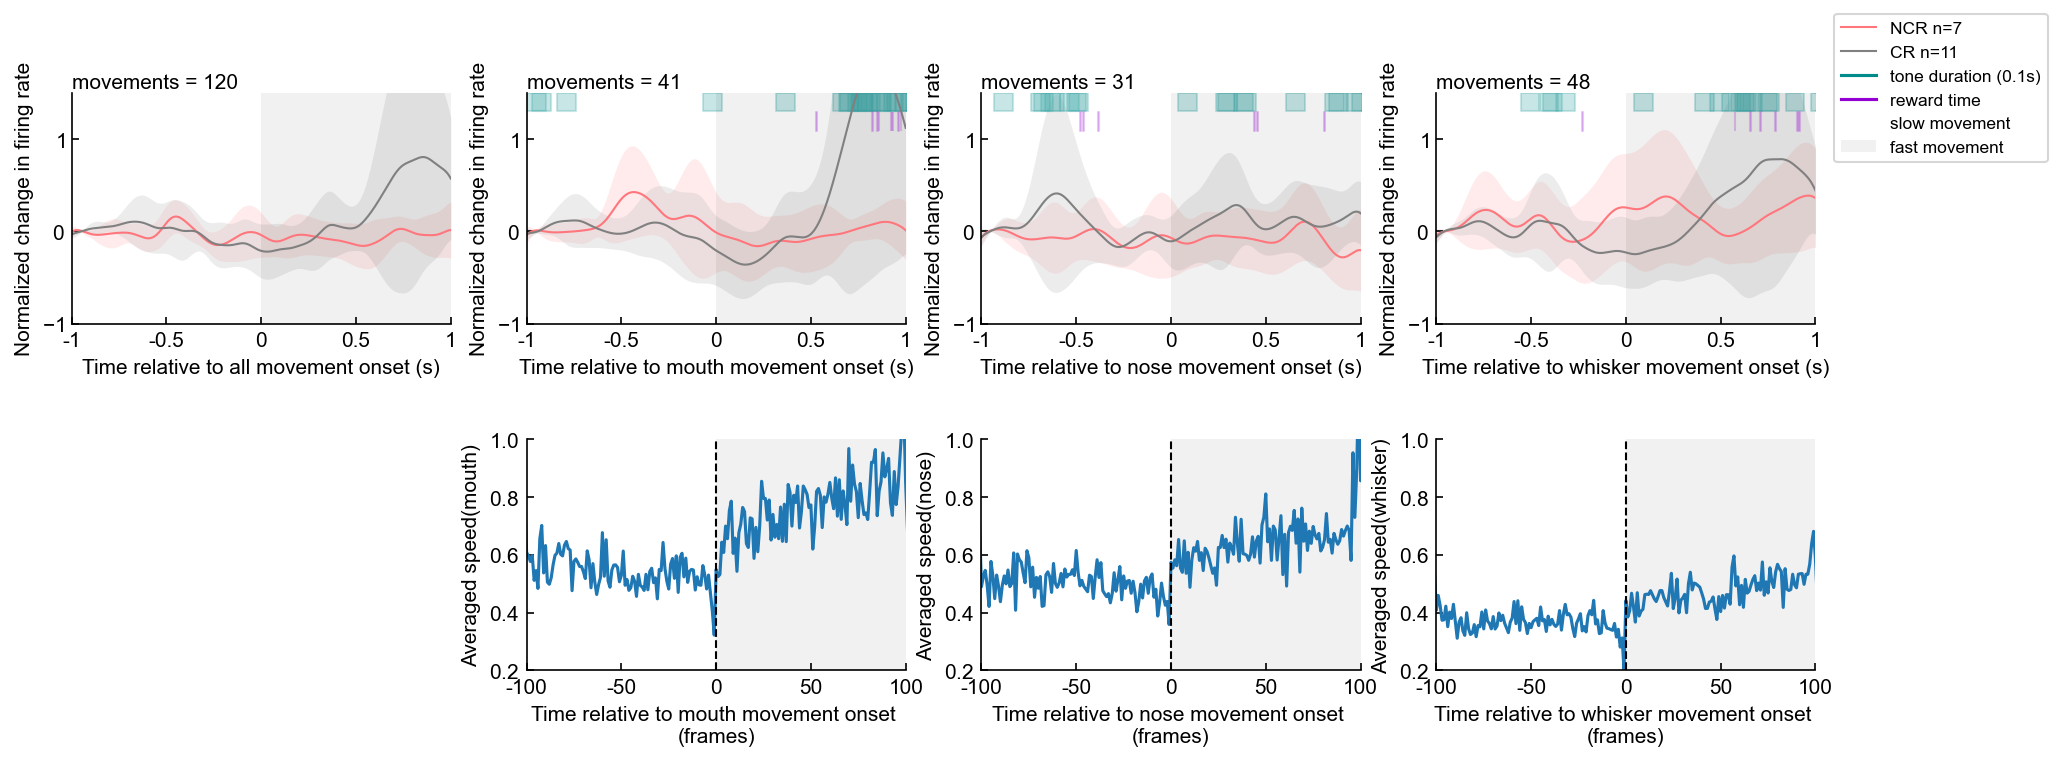

In [81]:
fig = visualizeClusterMovementAcrossCellsNormalizewithtonereward()
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion final\\png\\Normalized PSTH across all CRs and NCRs with tone and reward.png'),transparent=False,facecolor="white")
fig


In [82]:
#Save all in PDF: Plots with same y-axis for each cell in PSTH
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt, patches

file_PSTH = 'C:\\Users\insan\\Desktop\\Motion final\\Normalized PSTH across all CRs and NCRs with tone_reward time.pdf'
with PdfPages(file_PSTH) as pdf:
    pdf.savefig(fig)
    plt.close('all')

##################

meta NOT subset; don't know how to subset; dropped


In [83]:
#Unnormalized NCR plot

In [84]:
 def CalculateforRasterPSTHAcrossCells(movementsToPlots):
    
    def CalculateClustFR(clust):
        moveSpikes = []
        for movement in movementsToPlots:
            this_move_spike = ilep.getSpikeTimes(sessionfile_D9,clust=clust,starttime=movement-33000, endtime=movement+33000)
            moveSpikes.append(this_move_spike-movement)
        moveSpikes = np.array(moveSpikes,dtype='object') 
        
        bw_scott_factor = 3
        starttime = -30000 #samples
        endtime = starttime+60000 #samples
        xrange = np.linspace(starttime,endtime,num=1000)
        FR = np.full((10,len(xrange)),np.nan) 
        kf = KFold(n_splits=10)
    
        for idx,(move_index,_) in enumerate(kf.split(moveSpikes)):
            PSTHspikes = np.concatenate(moveSpikes[move_index])
            bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
            KDE = gaussian_kde(PSTHspikes,bw_method=bw)
            FR[idx,:] = KDE.evaluate(xrange)
            FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(move_index) *30000 #convert unit to seconds from samples
        
        avg_FR = np.mean(FR,axis=0) 
    
        return avg_FR 
    
    ###############  
    NCR_avg_FR = []
    for clust in NCR_D9:
        avg_FR = CalculateClustFR(clust)
        NCR_avg_FR.append(avg_FR)
    NCR_avg_FR = np.array(NCR_avg_FR)
     
    NCR_avg = np.mean(NCR_avg_FR,axis=0)
    NCR_sem = np.std(NCR_avg_FR,axis=0)
    #print(len(NCR_avg))
    
    max_FR_value = np.max(NCR_avg+NCR_sem) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ###
    CR_avg_FR = []
    for clust in CR_D9:
        avg_FR = CalculateClustFR(clust)
        CR_avg_FR.append(avg_FR)
    CR_avg_FR = np.array(CR_avg_FR)
     
    CR_avg = np.mean(CR_avg_FR,axis=0)
    CR_sem = np.std(CR_avg_FR,axis=0)
    
    CR_max_FR_value = np.max(CR_avg+CR_sem) * 1.1
    CR_idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,CR_max_FR_value)
    CR_valid_limits = sequence_of_possible_axis_limits[CR_idx_of_okay_limits]
    CR_limit = np.min(CR_valid_limits)
        
    return NCR_avg, NCR_sem, limit, CR_avg, CR_sem,CR_limit

In [85]:
print(CalculateforRasterPSTHAcrossCells(integrate_3003_movement_onset_samples_arr)[-1])
print(CalculateforRasterPSTHAcrossCells(mouth_3003_movement_onset_samples_arr)[-1])
print(CalculateforRasterPSTHAcrossCells(nose_3003_movement_onset_samples_arr)[-1])
print(CalculateforRasterPSTHAcrossCells(whisker_3003_movement_onset_samples_arr)[-1])
print(CalculateforRasterPSTHAcrossCells(integrate_3003_movement_onset_samples_arr)[2])
print(CalculateforRasterPSTHAcrossCells(mouth_3003_movement_onset_samples_arr)[2])
print(CalculateforRasterPSTHAcrossCells(nose_3003_movement_onset_samples_arr)[2])
print(CalculateforRasterPSTHAcrossCells(whisker_3003_movement_onset_samples_arr)[2])

30
30
30
30
8
6
12
8


In [86]:
def visualizeClusterMovementAcrossCells():
    movementsToPlots = [integrate_3003_movement_onset_samples_arr,mouth_3003_movement_onset_samples_arr,
                   nose_3003_movement_onset_samples_arr,whisker_3003_movement_onset_samples_arr]

    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    FRmod_color = NCR_CR_cmap( (FRmod-1)/5)
    #########################################################################################
    region = sessionfile.meta.region
    #########################################################################################

    fig = plt.figure(figsize=(15,5))
    #fig.suptitle('Unnormalized PSTH for all cells and speed plots')
    
    gs = fig.add_gridspec(2,4,height_ratios=[0.4,0.4],hspace=0.5)

    #Mouth
    ax2 = plt.subplot(gs[0,1])#PSTH
    #Nose
    ax3 = plt.subplot(gs[0,2],sharey=ax2)#PSTH
    #Whisker
    ax4 = plt.subplot(gs[0,3],sharey=ax2)#PSTH
    #Integrate
    ax1 = plt.subplot(gs[0,0],sharey=ax2)#PSTH - removed
    
    ax_PSTH = [ax2,ax3,ax4]
    
    ax5 = plt.subplot(gs[1,0],sharex=ax2)
    #Speed plot
    ax6 = plt.subplot(gs[1,1])
    ax7 = plt.subplot(gs[1,2],sharex=ax6)
    ax8 = plt.subplot(gs[1,3],sharex=ax6)
  

    ax5.spines['bottom'].set_visible(False)
    ax5.spines['left'].set_visible(False)
    ax5.get_xaxis().set_visible(False)
    ax5.get_yaxis().set_visible(False)
    ax5.scatter(np.random.rand(20),np.random.rand(20),color='r',alpha=0,s=1.5,marker='o',lw=0)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)

    #PSTH
    starttime = -30000 #samples
    endtime = starttime+60000 #samples
    xrange = np.linspace(starttime,endtime,num=1000)
    
    #Not show
    NCR_avg_FR_Integrate = CalculateforRasterPSTHAcrossCells(movementsToPlots[0])[0]
    NCR_sem_FR_Integrate = CalculateforRasterPSTHAcrossCells(movementsToPlots[0])[1]
    ax1.plot(xrange,NCR_avg_FR_Integrate, lw=1,color=NCR_COLOR,label = 'NCR',alpha=0)
    #ax1.fill_between(xrange,NCR_avg_FR_Integrate-NCR_sem_FR_Integrate,NCR_avg_FR_Integrate+NCR_sem_FR_Integrate,color=color,alpha=0.2,zorder=-10,lw=0)
    ax1.set_xlabel('Time relative to all movement onset (s)')
    
    #show
    NCR_avg_FR_Mouth = CalculateforRasterPSTHAcrossCells(movementsToPlots[1])[0]
    NCR_sem_FR_Mouth = CalculateforRasterPSTHAcrossCells(movementsToPlots[1])[1]
    ax2.plot(xrange,NCR_avg_FR_Mouth, lw=1,color=NCR_COLOR,label = 'NCR')
    ax2.fill_between(xrange,NCR_avg_FR_Mouth-NCR_sem_FR_Mouth,NCR_avg_FR_Mouth+NCR_sem_FR_Mouth,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
    CR_avg_FR_Mouth = CalculateforRasterPSTHAcrossCells(movementsToPlots[1])[3]
    CR_sem_FR_Mouth = CalculateforRasterPSTHAcrossCells(movementsToPlots[1])[4]
    ax2.plot(xrange,CR_avg_FR_Mouth, lw=1,color=CR_COLOR,label = 'CR')
    ax2.fill_between(xrange,CR_avg_FR_Mouth-CR_sem_FR_Mouth,CR_avg_FR_Mouth+CR_sem_FR_Mouth,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax2.set_xlabel('Time relative to mouth movement onset (s)')
    
    NCR_avg_FR_Nose = CalculateforRasterPSTHAcrossCells(movementsToPlots[2])[0]
    NCR_sem_FR_Nose = CalculateforRasterPSTHAcrossCells(movementsToPlots[2])[1]
    ax3.plot(xrange,NCR_avg_FR_Nose, lw=1,color=NCR_COLOR,label = 'NCR')
    ax3.fill_between(xrange,NCR_avg_FR_Nose-NCR_sem_FR_Nose,NCR_avg_FR_Nose+NCR_sem_FR_Nose,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
    CR_avg_FR_Nose = CalculateforRasterPSTHAcrossCells(movementsToPlots[2])[3]
    CR_sem_FR_Nose = CalculateforRasterPSTHAcrossCells(movementsToPlots[2])[4]
    ax3.plot(xrange,CR_avg_FR_Nose, lw=1,color=CR_COLOR,label = 'CR')
    ax3.fill_between(xrange,CR_avg_FR_Nose-CR_sem_FR_Nose,CR_avg_FR_Nose+CR_sem_FR_Nose,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax3.set_xlabel('Time relative to nose movement onset (s)')
    
    NCR_avg_FR_Whisker = CalculateforRasterPSTHAcrossCells(movementsToPlots[3])[0]
    NCR_sem_FR_Whisker = CalculateforRasterPSTHAcrossCells(movementsToPlots[3])[1]
    ax4.plot(xrange,NCR_avg_FR_Whisker, lw=1,color=NCR_COLOR,label = 'NCR n=7')
    ax4.fill_between(xrange,NCR_avg_FR_Whisker-NCR_sem_FR_Whisker,NCR_avg_FR_Whisker+NCR_sem_FR_Whisker,color=NCR_COLOR,alpha=0.2,zorder=-10,lw=0)
    CR_avg_FR_Whisker = CalculateforRasterPSTHAcrossCells(movementsToPlots[3])[3]
    CR_sem_FR_Whisker = CalculateforRasterPSTHAcrossCells(movementsToPlots[3])[4]
    ax4.plot(xrange,CR_avg_FR_Whisker, lw=1,color=CR_COLOR,label = 'CR n=11')
    ax4.fill_between(xrange,CR_avg_FR_Whisker-CR_sem_FR_Whisker,CR_avg_FR_Whisker+CR_sem_FR_Whisker,color=CR_COLOR,alpha=0.2,zorder=-10,lw=0)
    ax4.set_xlabel('Time relative to whisker movement onset (s)')
    
    highest_limit = 30
    ax1.set_ylim([0,highest_limit])
    ax1.set_yticks([0,highest_limit/2,highest_limit])
    #ax1.set_yticklabels(['0.2','0.6','1.0']) #plot purpose
    ax1.set_yticklabels(['0',str(int(highest_limit/2)),str(highest_limit)]) #real

    for ax in ax_PSTH:
        ax.axvspan(-30000,0, ymin=0,color='white', alpha=0.3, lw=0,label='slow movement') 
        ax.axvspan(0, 30000, ymin=0,color='lightgray', alpha=0.3, lw=0, label = 'fast movement')
        ax.set_ylabel('Firing rate (spikes/s)')
        ax.set_xlim([-30000,30000])
        ax.set_xticks([-30000,-15000,0,15000, 30000])
        #ax.set_xticklabels(['-100','-0.5','0','0.5','1'])#plot purpose
        ax.set_xticklabels(['-1','-0.5','0','0.5','1'])#real
        #ax.text(18000,highest_limit,'NCR n=7',color=NCR_COLOR)
        #ax.text(18000,highest_limit+3,'CR n=11',color=CR_COLOR)

    ax4.legend(frameon=True,loc=(1.05,0.7))
    
    #Speed plot
    #Mouth speed plot
    ax6.plot(avg_mouth_3003_speed,color='#969696')
    ax6.set_xlim([0,400])
    #ax6.set_xticklabels(['-100','-50','0','50','100'])
    ax6.set_ylabel('Averaged speed (mouth)')
    ax6.set_xlabel('Time relative to mouth movement onset \n(frames)')
    #ax6.axvline(200,color='black',linestyle='--',zorder=10,lw=1)
    ax6.set_yticks([0.2,0.6,1])
    ax6.set_ylim([0.2,1])
    ax6.axvspan(200, 300, ymin=0,color='lightgray', alpha=0.3, lw=0)
    
    #Nose speed plot
    ax7.plot(avg_nose_3003_speed,color='#969696')
    ax7.set_xlim([100,300])
    ax7.set_xticklabels(['-100','-50','0','50','100'])
    ax7.set_ylabel('Averaged speed (nose)')
    ax7.set_xlabel('Time relative to nose movement onset \n(frames)')
    #ax7.axvline(200,color='black',linestyle='--',zorder=10,lw=1)
    ax7.set_yticks([0.2,0.6,1])
    ax7.set_ylim([0.2,1])
    ax7.axvspan(200, 300, ymin=0,color='lightgray', alpha=0.3, lw=0)
    
    #Whisker speed plot
    ax8.plot(avg_whisker_3003_speed,color='#969696')
    ax8.set_xlim([100,300])
    ax8.set_xticklabels(['-100','-50','0','50','100'])
    ax8.set_ylabel('Averaged speed (whisker)')
    ax8.set_xlabel('Time relative to whisker movement onset \n(frames)')
    #ax8.axvline(200,color='black',linestyle='--',zorder=10,lw=1)
    ax8.set_yticks([0.2,0.6,1])
    ax8.set_ylim([0.2,1])
    ax8.axvspan(200, 300, ymin=0,color='lightgray', alpha=0.3, lw=0)
    
    plt.close()
    return fig

In [87]:
fig = visualizeClusterMovementAcrossCells()
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Motion final\\png\\Unnormalized PSTH across all NCRs and CRs.png'),transparent=False,facecolor="white")
fig

#Save all in PDF: Plots with same y-axis for each cell in PSTH
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt, patches

file_PSTH = 'C:\\Users\insan\\Desktop\\Motion final\\Unnormalized PSTH across all NCRs and CRs.pdf'
with PdfPages(file_PSTH) as pdf:
    pdf.savefig(fig)
    plt.close('all')

C:\Users\insan\AppData\Local\Temp\ipykernel_14808\1899987377.py:121: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax7.set_xticklabels(['-100','-50','0','50','100'])
C:\Users\insan\AppData\Local\Temp\ipykernel_14808\1899987377.py:132: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax8.set_xticklabels(['-100','-50','0','50','100'])
meta NOT subset; don't know how to subset; dropped


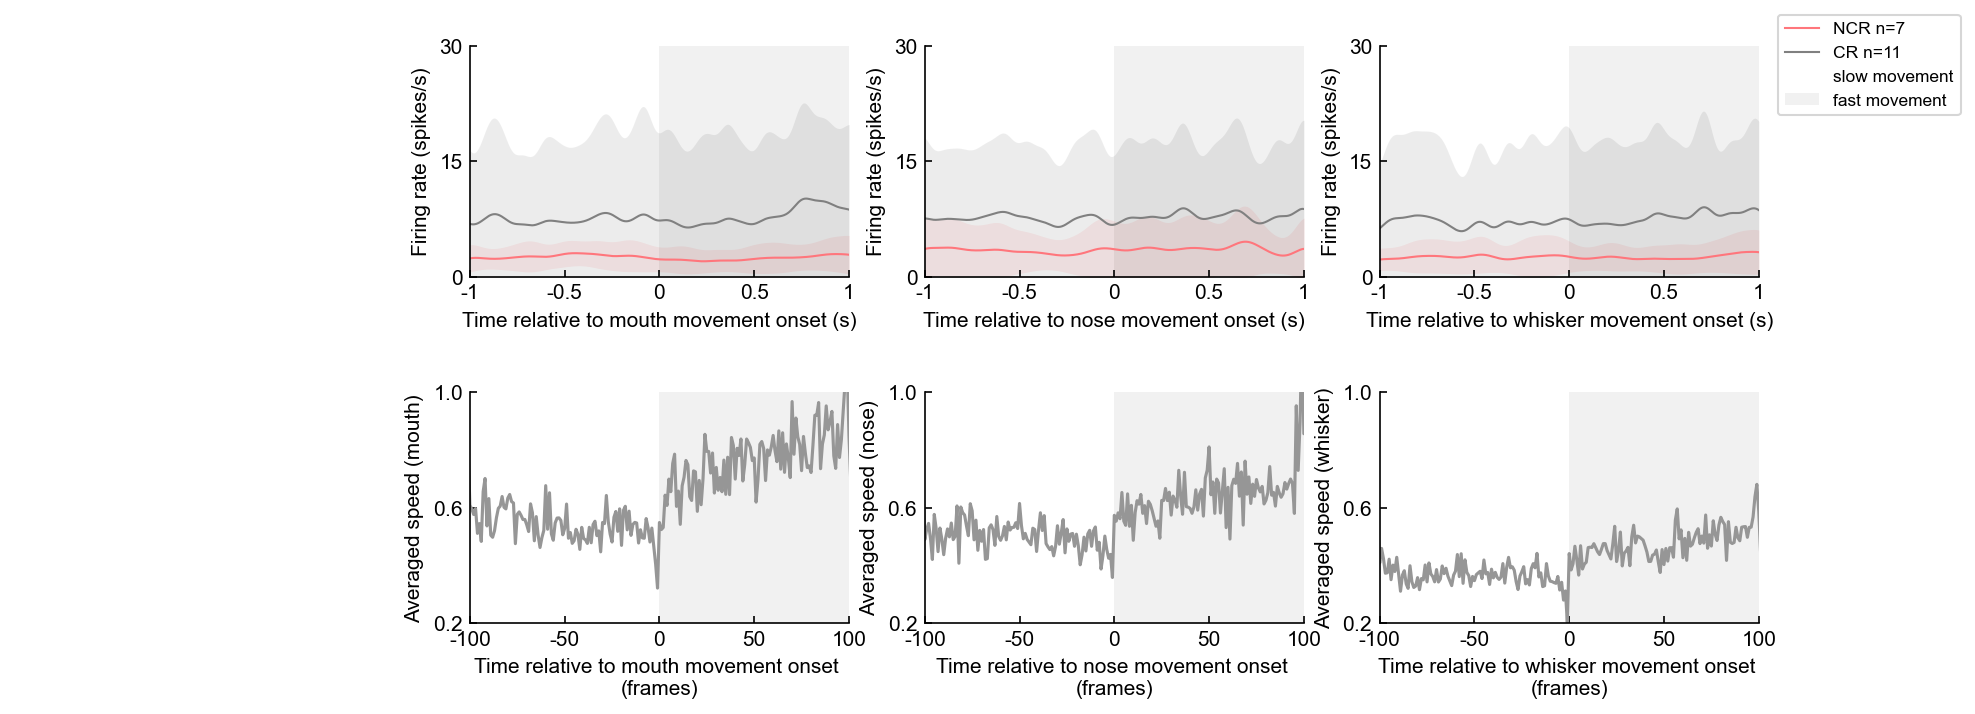

In [88]:
fig

In [89]:
# (timefile3[7479] - timefile3[7380])*30000